In [1]:
import sys
import os
from pathlib import Path
import importlib

# The notebooks are in a 'notebooks' subfolder, so workspace root is one level up
# This works if notebook is in notebooks/ folder
workspace_root = Path.cwd().parent.resolve()

# Add workspace root to path so we can import from src
sys.path.insert(0, str(workspace_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src import pvgis_pi_heatmap
importlib.reload(pvgis_pi_heatmap)  # Reload to pick up any changes

from src.pvgis_pi_heatmap import make_random_greece_meta, compute_pi_anomaly, short_label, parse_kwp_from_header
from src.utils import save_figure

# Store workspace root for use in other cells
WORKSPACE_ROOT = workspace_root


In [ ]:
DATA_DIR = WORKSPACE_ROOT / "data"
DATA_XLSX = DATA_DIR / "daily_energy.xlsx"
DATA_XLSX_HISTORICAL = DATA_DIR / "daily_energy_historical.xlsx"
CACHE_DIR = WORKSPACE_ROOT / "pvgis_cache"
PLOTS_DIR = WORKSPACE_ROOT / "plots"

df = pd.read_excel(DATA_XLSX)

# Expect Timestamp column exactly
df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df["date"] = df["Timestamp"].dt.normalize()

park_cols = [c for c in df.columns if c not in ["Timestamp", "date"]]
daily = df.set_index("date")[park_cols].sort_index()

daily.head()


,[4E Energeiaki 176 KWp Likovouni] PCC PCC active energy export (kWh),[4E Energeiaki 4472 KWp Lexaina] PCC PCC active energy export (kWh),[4E Energeiaki 805 KWp Darali] PCC PCC active energy export (kWh),[Fragiatoula_Utilitas_4866kWp] PCC PCC active energy export (kWh),[Hliatoras 474kWp Andravida] PCC PCC active energy export (kWh),"[Ntarali_Bonitas_0,45MW] PCC PCC active energy export (kWh)",[Ntarali_Concept_296KW] PCC PCC active energy export (kWh),[Ntarali_Concept_320KW] PCC PCC active energy export (kWh),[Ntarali_Concept_592KW] PCC PCC active energy export (kWh),[Ntarali_Konenergy_590KW] PCC PCC active energy export (kWh),...,[Solar Concept 276 KWp Likovouni] PCC PCC active energy export (kWh),[Solar Concept 3721 KWp Lexaina] PCC PCC active energy export (kWh),[Solar Datum 2910 KWp Lexaina] PCC PCC active energy export (kWh),[Solar Datum 864 KWp Darali] PCC PCC active energy export (kWh),[Solar Factory 494kWp Andravida] PCC PCC active energy export (kWh),[Spes Solaris 1527 KWp Darali] PCC PCC active energy export (kWh),[Spes Solaris 1986 KWp Lexaina] PCC PCC active energy export (kWh),[Spes Solaris 201 KWp Konizos] PCC PCC active energy export (kWh),[Spes Solaris 500 KWp Kavasila] PCC PCC active energy export (kWh),[Spes Solaris 805 KWp Konizos] PCC PCC active energy export (kWh)
date,,,,,,,,,,,,,,,,,,,,,
2025-01-01,707.263906,13690.78810,3178.12297,19497.56420,1862.90557,1624.783880,NaN,1181.988620,2343.075250,NaN,...,1118.412100,11802.72260,7519.99269,3506.26624,1872.157000,5388.02787,7282.26884,771.653313,1752.171110,3221.45495
2025-01-02,535.072437,12303.91170,2441.87001,16099.87970,1665.58718,1233.700520,NaN,955.627782,1799.238900,NaN,...,831.657080,10555.61630,6713.96331,2695.92049,1676.809360,4171.37447,6536.09108,600.560434,1503.064440,2528.99129
2025-01-03,715.491591,8690.20766,3158.18414,11886.49750,1200.96122,1625.586510,NaN,1227.271100,2324.039020,NaN,...,1127.917000,6535.99875,4720.39404,3492.12314,1216.047450,5339.43444,4605.84629,765.395146,1127.577790,3192.74539
2025-01-04,274.682227,4652.46671,1205.84061,5857.67208,641.19915,626.812243,NaN,448.490281,901.944051,NaN,...,435.395871,3255.48212,2614.41776,1323.15072,661.702906,1908.72506,2530.47494,298.126989,613.654995,1245.83766
2025-01-05,617.347141,11928.90140,3070.94270,19818.53920,1796.94311,1547.586170,NaN,1199.117510,2262.057810,NaN,...,987.905573,11271.91760,3857.56946,3354.53064,1697.702930,5026.97647,6796.93482,706.645516,1767.604440,3000.81426


In [3]:
# Export park column names to CSV
output_path = WORKSPACE_ROOT / "outputs" / "park_columns.csv"
output_path.parent.mkdir(exist_ok=True)

# Create DataFrame with park names
park_cols_df = pd.DataFrame({
    'park_name': park_cols
})

# Save to CSV
park_cols_df.to_csv(output_path, index=False)
print(f"✓ Exported {len(park_cols)} park columns to: {output_path}")
print(f"\nFirst 10 parks:")
print(park_cols_df.head(10))

✓ Exported 22 park columns to: C:\00_Developement\daily_avg_pv_kpi_heatmap\outputs\park_columns.csv

First 10 parks:
                                           park_name
0  [4E Energeiaki 176 KWp Likovouni] PCC PCC acti...
1  [4E Energeiaki 4472 KWp Lexaina] PCC PCC activ...
2  [4E Energeiaki 805 KWp Darali] PCC PCC active ...
3  [Fragiatoula_Utilitas_4866kWp] PCC PCC active ...
4  [Hliatoras 474kWp Andravida] PCC PCC active en...
5  [Ntarali_Bonitas_0,45MW] PCC PCC active energy...
6  [Ntarali_Concept_296KW] PCC PCC active energy ...
7  [Ntarali_Concept_320KW] PCC PCC active energy ...
8  [Ntarali_Concept_592KW] PCC PCC active energy ...
9  [Ntarali_Konenergy_590KW] PCC PCC active energ...


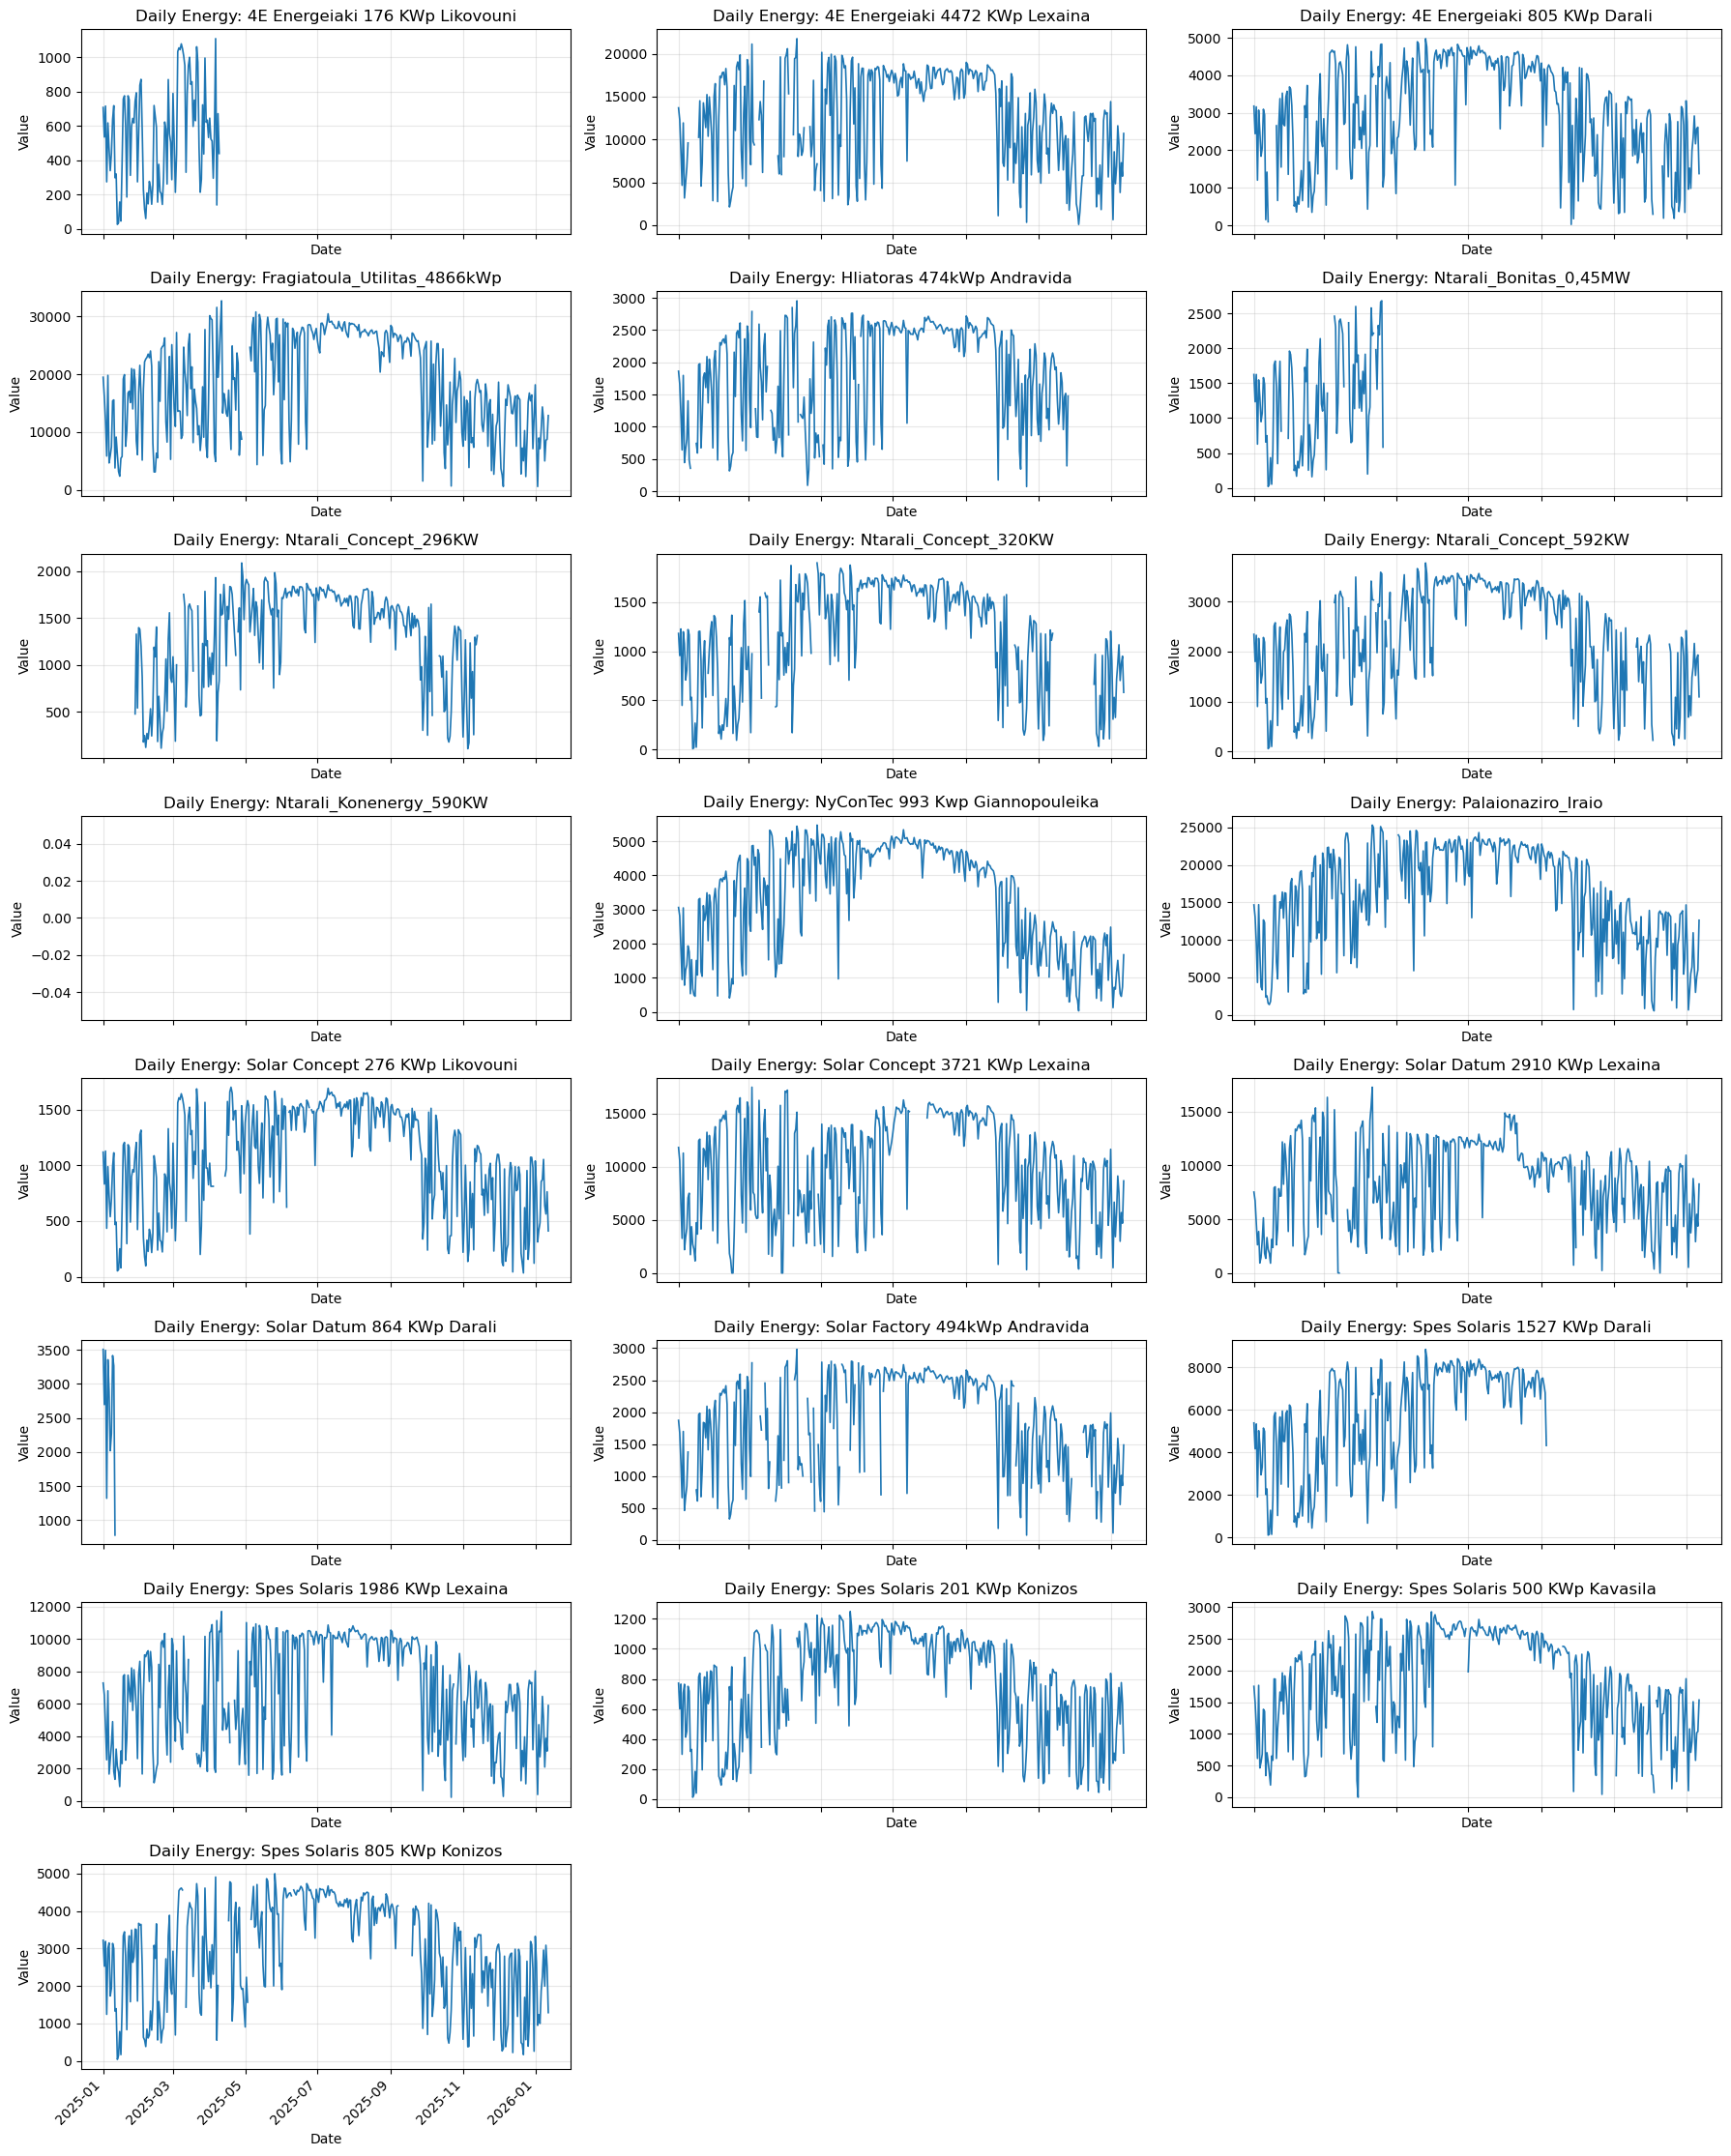

In [4]:
def lineplot_timeseries_per_column(
    df: pd.DataFrame,
    title_prefix: str = "Time Series",
    ncols: int = 3,
    sharex: bool = True,
    sharey: bool = False,
    save: bool = False,
    save_dir: str | Path | None = None,
    base_filename: str | None = None,
    dpi: int = 150,
    fmt: str = "png",
):
    """
    Plot one line chart per column in a grid of subplots and optionally save the figure.

    Parameters:
    -----------
    df: pd.DataFrame
        Date-indexed DataFrame; each column is a park/series.
    title_prefix: str
        Prefix used in subplot titles and default filename.
    ncols: int
        Number of columns in the subplot grid.
    sharex/sharey: bool
        Share axes across subplots.
    save: bool
        If True, saves the figure.
    save_dir: str | Path | None
        Directory where the figure will be saved. If None and `save=True`,
        pass a directory explicitly (e.g., PLOTS_DIR) or it will fallback to CWD/"plots".
    base_filename: str | None
        Base filename without extension; if None, derived from title_prefix.
    dpi: int
        Resolution for the saved image.
    fmt: str
        File format for saving (e.g., "png", "pdf", "svg").
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from pathlib import Path

    cols = list(df.columns)
    if len(cols) == 0:
        print("No columns to plot.")
        return None

    n = len(cols)
    nrows = int(np.ceil(n / ncols))
    figsize = (min(6 * ncols, 24), max(2.8 * nrows, 4))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, sharex=sharex, sharey=sharey)
    if nrows == 1:
        axes = np.array([axes])
    if ncols == 1:
        axes = axes.reshape(nrows, 1)

    axes_flat = axes.ravel()

    for i, col in enumerate(cols):
        ax = axes_flat[i]
        ax.plot(df.index, df[col], linewidth=1.2)
        try:
            label = short_label(col)
        except Exception:
            label = col
        ax.set_title(f"{title_prefix}: {label}")
        ax.grid(alpha=0.3)
        ax.set_xlabel("Date")
        ax.set_ylabel("Value")

    for j in range(len(cols), len(axes_flat)):
        axes_flat[j].set_visible(False)

    for ax in axes_flat[:len(cols)]:
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
            tick.set_ha('right')

    plt.tight_layout()

    # Use shared save utility
    saved_path = save_figure(
        fig=fig,
        title_prefix=title_prefix,
        save=save,
        save_dir=save_dir,
        base_filename=base_filename,
        dpi=dpi,
        fmt=fmt,
    )

    plt.show()
    return saved_path

_ = lineplot_timeseries_per_column(
    daily,
    title_prefix="Daily Energy",
    ncols=3,
    sharex=True,
    sharey=False,
    save=True,
    save_dir=PLOTS_DIR,
    base_filename="daily_energy_timeseries_grid",
    dpi=180,
    fmt="png",
)

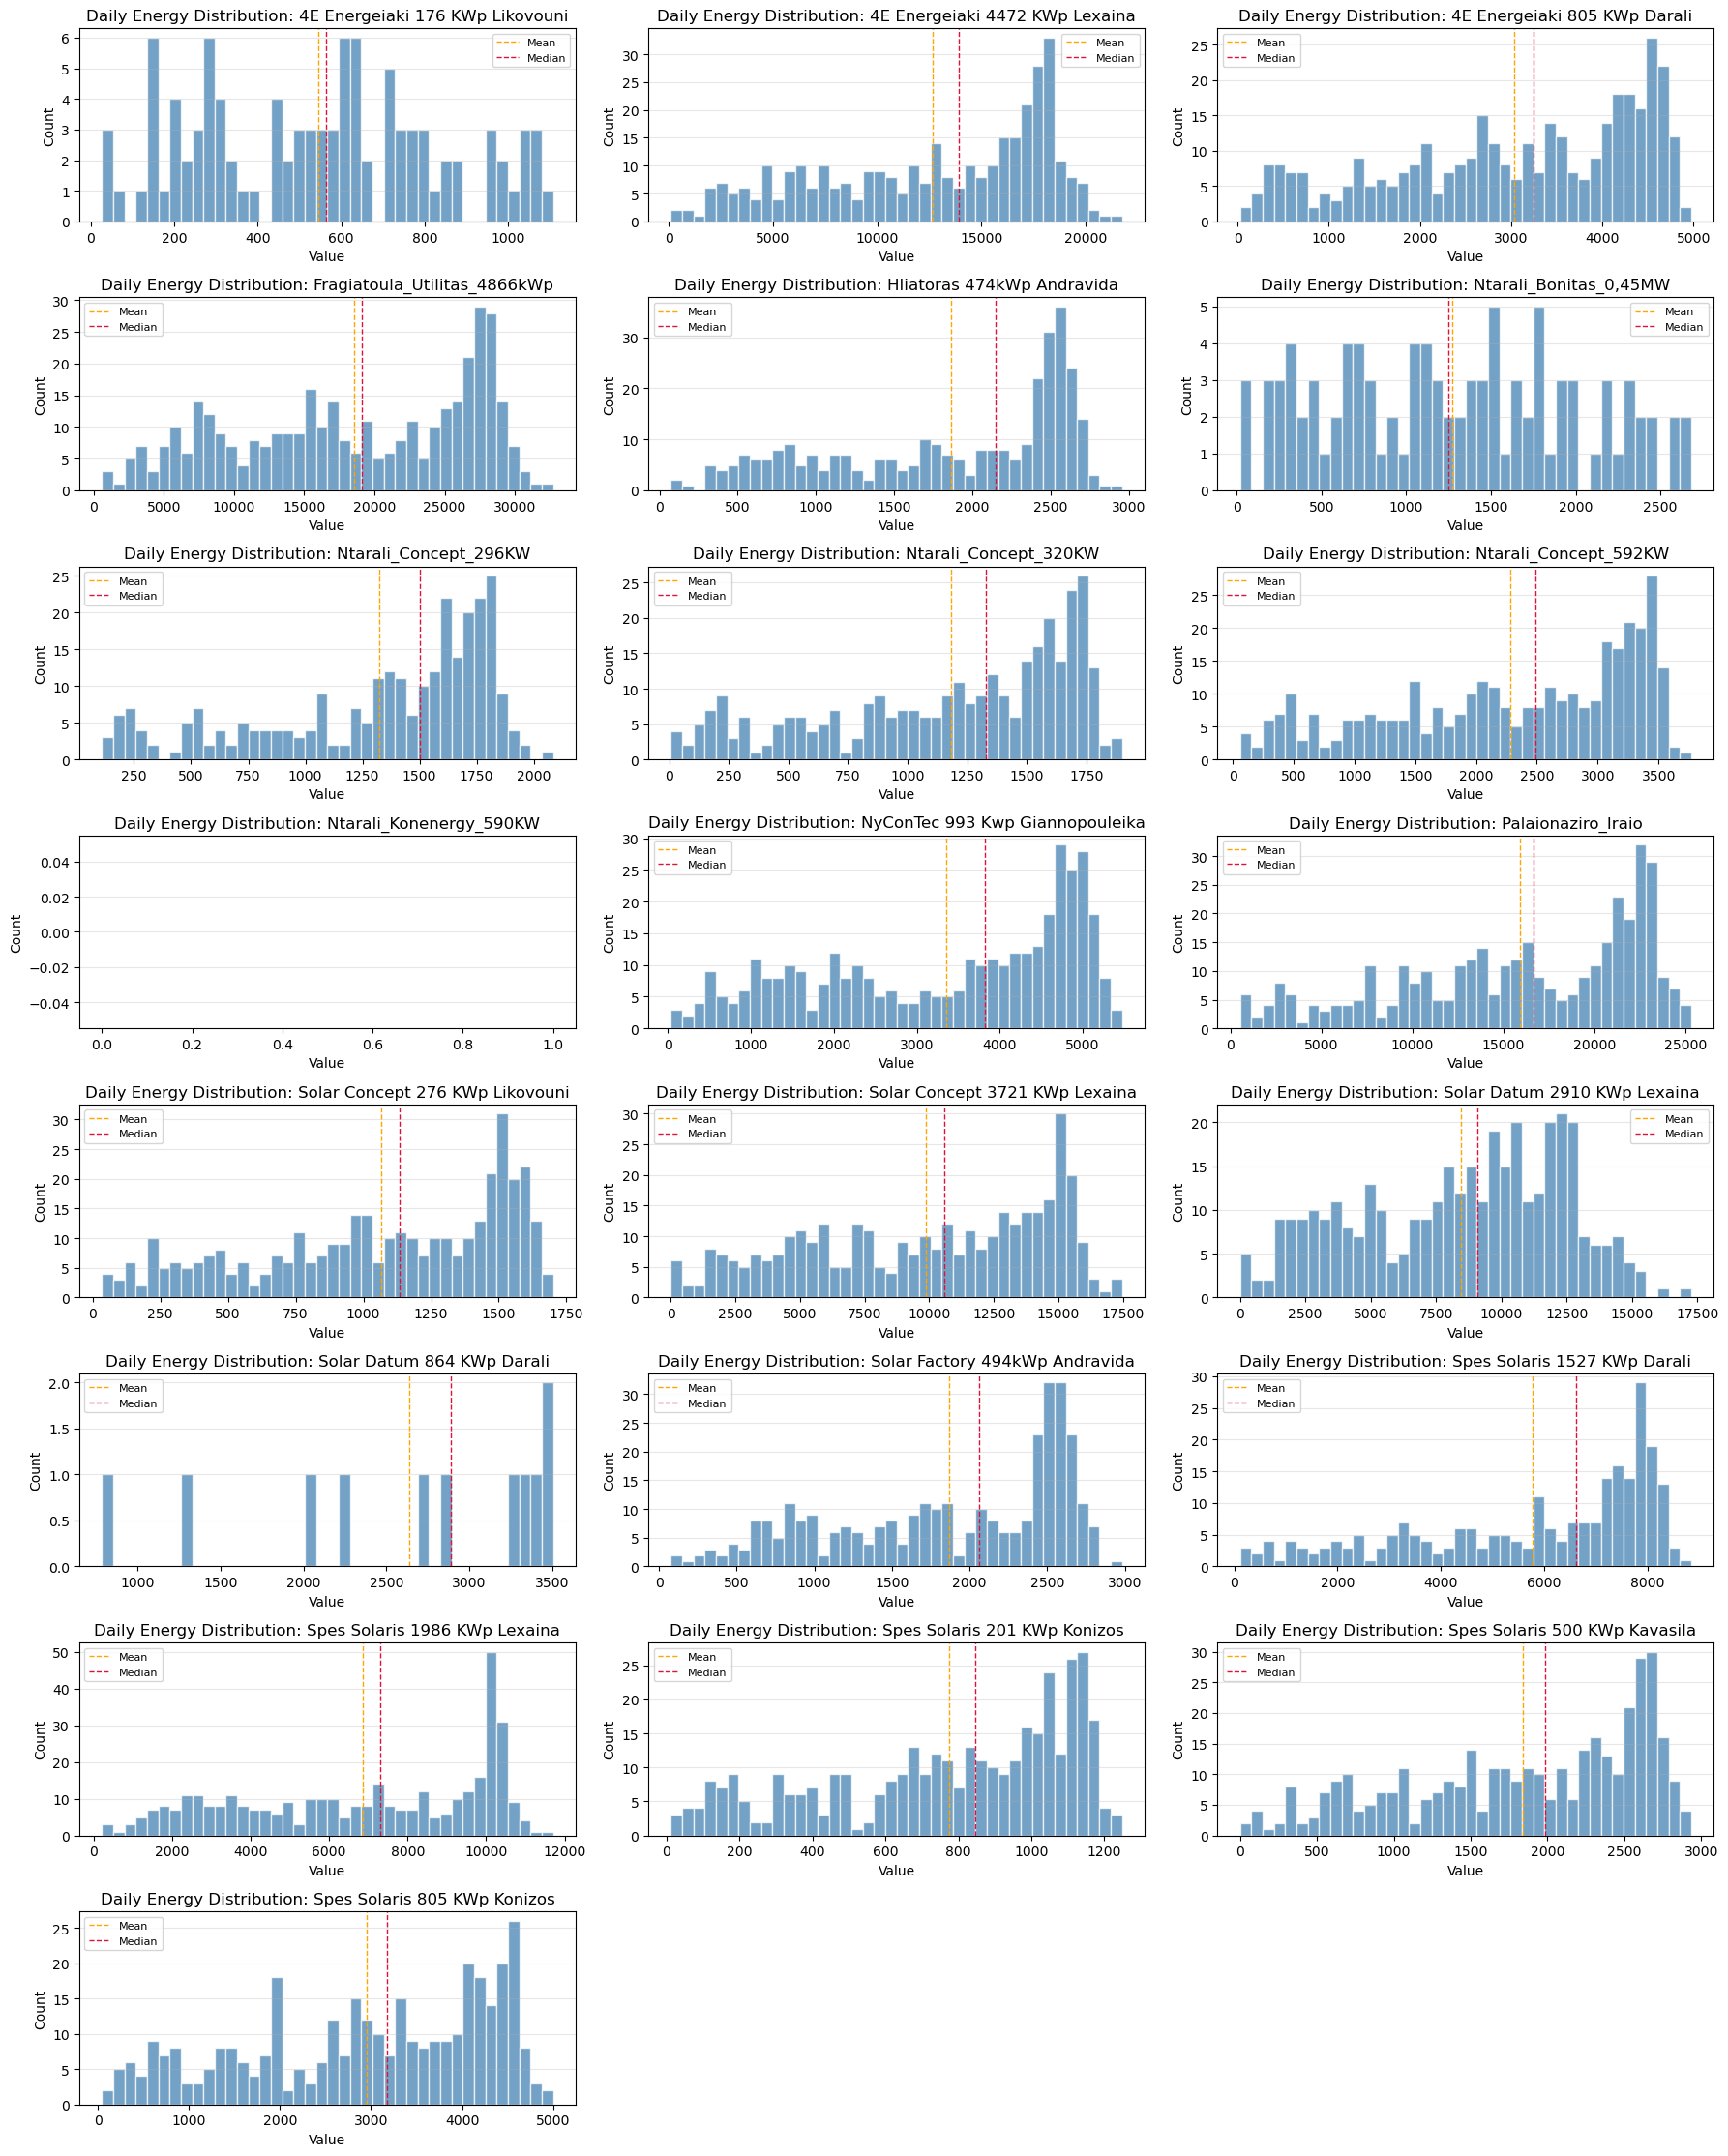

In [5]:
def histplot_distribution_per_column(
    df: pd.DataFrame,
    title_prefix: str = "Distribution",
    ncols: int = 3,
    bins: int = 30,
    density: bool = False,
    dropna: bool = True,
    sharex: bool = False,
    sharey: bool = False,
    show_stats: bool = True,
    save: bool = False,
    save_dir: str | Path | None = None,
    base_filename: str | None = None,
    dpi: int = 150,
    fmt: str = "png",
):
    """
    Plot one histogram per column in a grid of subplots and optionally save the figure.

    Parameters:
    -----------
    df: pd.DataFrame
        DataFrame indexed by date; each column is a park/series.
    title_prefix: str
        Prefix used in subplot titles and default filename.
    ncols: int
        Number of columns in the subplot grid.
    bins: int
        Histogram bin count.
    density: bool
        If True, normalize histogram to form a probability density.
    dropna: bool
        If True, exclude NaNs from each column.
    sharex/sharey: bool
        Share axes across subplots.
    show_stats: bool
        If True, draw vertical lines for mean and median.
    save: bool
        If True, saves the figure.
    save_dir: str | Path | None
        Directory where the figure will be saved. If None and `save=True`,
        pass a directory explicitly (e.g., PLOTS_DIR) or it will fallback to CWD/"plots".
    base_filename: str | None
        Base filename without extension; if None, derived from title_prefix.
    dpi: int
        Resolution for the saved image.
    fmt: str
        File format for saving (e.g., "png", "pdf", "svg").
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from pathlib import Path

    cols = list(df.columns)
    if len(cols) == 0:
        print("No columns to plot.")
        return None

    n = len(cols)
    nrows = int(np.ceil(n / ncols))
    figsize = (min(6 * ncols, 24), max(2.8 * nrows, 4))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, sharex=sharex, sharey=sharey)
    if nrows == 1:
        axes = np.array([axes])
    if ncols == 1:
        axes = axes.reshape(nrows, 1)

    axes_flat = axes.ravel()

    for i, col in enumerate(cols):
        ax = axes_flat[i]
        values = df[col]
        if dropna:
            values = values.dropna()

        ax.hist(values, bins=bins, alpha=0.75, color='steelblue', edgecolor='white', density=density)

        try:
            label = short_label(col)
        except Exception:
            label = col
        ax.set_title(f"{title_prefix}: {label}")
        ax.grid(axis='y', alpha=0.3)
        ax.set_xlabel("Value")
        ax.set_ylabel("Density" if density else "Count")

        if show_stats and len(values) > 0:
            mean_val = float(values.mean())
            median_val = float(values.median())
            ax.axvline(mean_val, color='orange', linestyle='--', linewidth=1, label='Mean')
            ax.axvline(median_val, color='crimson', linestyle='--', linewidth=1, label='Median')
            ax.legend(fontsize=8)

    # Hide any unused axes
    for j in range(len(cols), len(axes_flat)):
        axes_flat[j].set_visible(False)

    plt.tight_layout()

    # Use shared save utility
    saved_path = save_figure(
        fig=fig,
        title_prefix=title_prefix,
        save=save,
        save_dir=save_dir,
        base_filename=base_filename,
        dpi=dpi,
        fmt=fmt,
    )

    plt.show()
    return saved_path

# Example: plot one histogram per column
_ = histplot_distribution_per_column(
    daily,
    title_prefix="Daily Energy Distribution",
    ncols=3,
    bins=40,
    density=False,
    save=True,
    save_dir=PLOTS_DIR,
    base_filename="daily_energy_hist_grid",
    dpi=180,
    fmt="png",
)


In [12]:
def compute_descriptive_statistics(
    df: pd.DataFrame,
    round_digits: int = 2,
    cmap: str = "Blues",
    sort_by: str | None = "Mean",
    ascending: bool = False,
    top_n: int | None = None,
    show: bool = True,
):
    """
    Compute and display descriptive statistics with a styled, visual summary.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame indexed by date; columns are series/parks.
    round_digits : int
        Number of decimal places for numeric formatting.
    cmap : str
        Colormap name for background gradients.
    sort_by : str | None
        Optional column to sort by (e.g., "Mean", "Median", "Missing %").
    ascending : bool
        Sort ascending or descending when `sort_by` is provided.
    top_n : int | None
        If provided, display only the top N rows after sorting.
    show : bool
        If True, renders a styled table; otherwise returns the (stats, styler).

    Returns
    -------
    pd.DataFrame | tuple[pd.DataFrame, pd.io.formats.style.Styler]
    """
    import numpy as np
    from IPython.display import display

    # Base descriptive stats
    desc = df.describe(percentiles=[0.25, 0.5, 0.75]).T

    # Additional metrics
    median = df.median()
    var = df.var()
    skew = df.skew()
    kurt = df.kurtosis()

    missing_count = df.isna().sum()
    total_rows = df.shape[0]
    missing_pct = (missing_count / total_rows * 100.0).replace([np.inf, -np.inf], np.nan)

    non_nan_count = df.notna().sum()
    zero_count = df.eq(0).sum()
    zero_pct = (zero_count / non_nan_count * 100.0).replace([np.inf, -np.inf], np.nan)

    # Assemble
    stats = pd.DataFrame({
        "Count": desc["count"],
        "Missing Count": missing_count,
        "Missing %": missing_pct,
        "Zero Count": zero_count,
        "Zero %": zero_pct,
        "Mean": desc["mean"],
        "Median": median,
        "Std": desc["std"],
        "Variance": var,
        "Skew": skew,
        "Kurtosis": kurt,
        "Min": desc["min"],
        "Q1 (25%)": desc["25%"],
        "Q3 (75%)": desc["75%"],
        "Max": desc["max"],
    })

    # Optional sort and limit
    if sort_by is not None and sort_by in stats.columns:
        stats = stats.sort_values(by=sort_by, ascending=ascending)
    if top_n is not None and top_n > 0:
        stats = stats.head(top_n)

    # Round for display
    stats_rounded = stats.round(round_digits)

    # Build a Styler with visual cues
    subset_gradient = [
        "Mean", "Median", "Std", "Variance", "Skew", "Kurtosis", "Min", "Q1 (25%)", "Q3 (75%)", "Max"
    ]
    subset_bar = ["Missing %", "Zero %"]

    styler = (
        stats_rounded.style
        .set_caption("Descriptive Statistics per Series")
        .background_gradient(cmap=cmap, subset=[c for c in subset_gradient if c in stats_rounded.columns])
        .bar(subset=[c for c in subset_bar if c in stats_rounded.columns], color="#FDAE61")
        .format(precision=round_digits)
        .set_table_styles([
            {"selector": "th.col_heading", "props": "text-align: center;"},
            {"selector": "th.row_heading", "props": "text-align: left;"},
            {"selector": "caption", "props": "caption-side: top; font-weight: bold; font-size: 1.1em;"},
        ])
        .set_properties(**{"text-align": "right"})
    )

    if show:
        display(styler)
        return stats
    else:
        return stats, styler

# Render styled stats by default
_ = compute_descriptive_statistics(daily, round_digits=2, cmap="Blues", sort_by="Missing %", ascending=False)


,Count,Missing Count,Missing %,Zero Count,Zero %,Mean,Median,Std,Variance,Skew,Kurtosis,Min,Q1 (25%),Q3 (75%),Max
[Ntarali_Konenergy_590KW] PCC PCC active energy export (kWh),0.00,377,100.00,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
[Solar Datum 864 KWp Darali] PCC PCC active energy export (kWh),11.00,366,97.08,0,0.00,2637.76,2891.65,935.48,875120.25,-0.98,-0.12,782.62,2144.46,3385.17,3506.27
"[Ntarali_Bonitas_0,45MW] PCC PCC active energy export (kWh)",96.00,281,74.54,0,0.00,1272.03,1247.04,724.98,525595.75,0.11,-1.00,18.41,664.52,1804.25,2681.77
[4E Energeiaki 176 KWp Likovouni] PCC PCC active energy export (kWh),99.00,278,73.74,0,0.00,544.34,564.64,289.42,83764.09,0.12,-0.95,26.93,288.49,751.07,1107.63
[Spes Solaris 1527 KWp Darali] PCC PCC active energy export (kWh),247.00,130,34.48,0,0.00,5783.41,6616.92,2345.71,5502337.94,-0.80,-0.57,112.98,4134.97,7762.90,8849.03
[Ntarali_Concept_296KW] PCC PCC active energy export (kWh),277.00,100,26.53,0,0.00,1325.12,1503.62,504.06,254079.59,-0.93,-0.29,109.07,1022.54,1729.22,2085.11
[Hliatoras 474kWp Andravida] PCC PCC active energy export (kWh),316.00,61,16.18,0,0.00,1862.37,2145.58,763.57,583038.03,-0.63,-1.00,72.87,1190.20,2522.39,2956.11
[Ntarali_Concept_320KW] PCC PCC active energy export (kWh),321.00,56,14.85,0,0.00,1182.20,1329.74,519.26,269634.22,-0.69,-0.73,6.51,819.19,1633.90,1900.63
[Solar Factory 494kWp Andravida] PCC PCC active energy export (kWh),326.00,51,13.53,0,0.00,1866.78,2062.23,744.85,554807.52,-0.57,-0.98,76.35,1243.48,2534.17,2982.29
[4E Energeiaki 4472 KWp Lexaina] PCC PCC active energy export (kWh),345.00,32,8.49,0,0.00,12674.46,13920.60,5425.46,29435611.45,-0.51,-0.98,91.83,8090.20,17568.00,21763.97


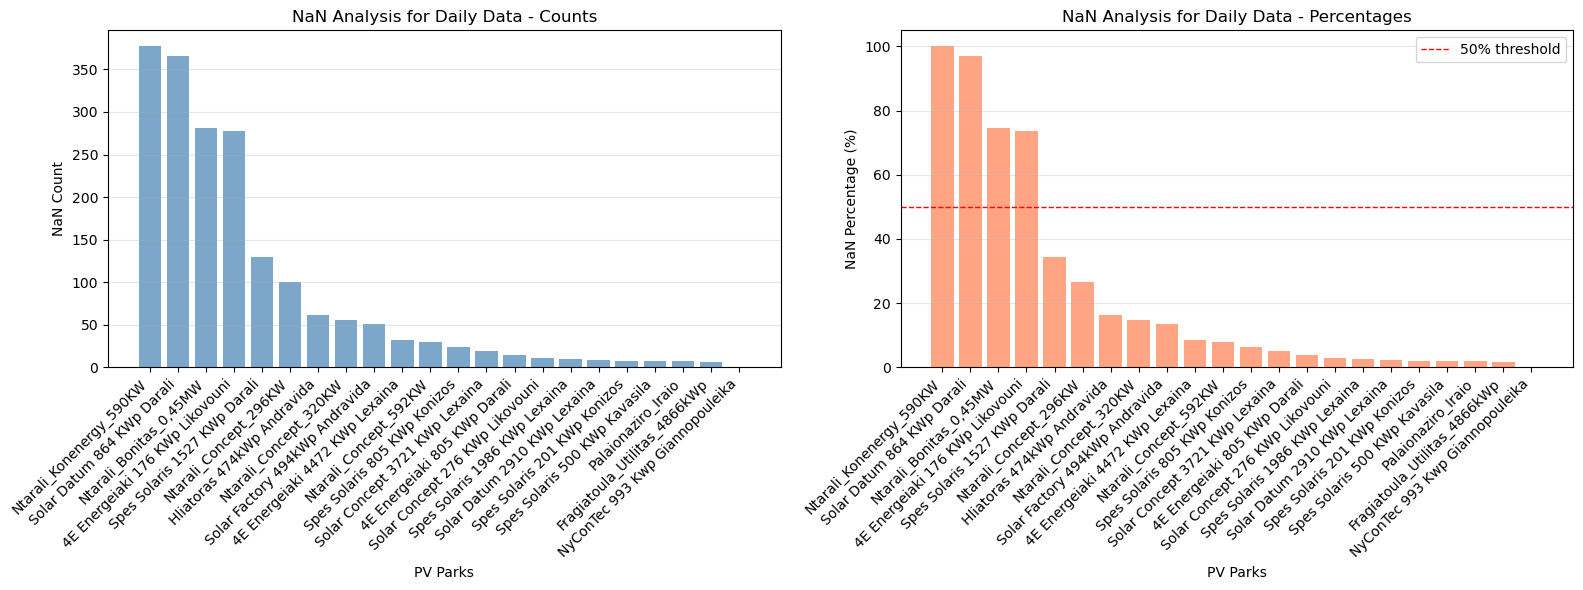


Total columns: 22
Columns with NaN: 22
Columns with >50% NaN: 4


In [13]:
def barplot_nan_count(
    df: pd.DataFrame,
    title: str = "NaN Count per Column",
    save: bool = False,
    save_dir: str | Path | None = None,
    base_filename: str | None = None,
    dpi: int = 150,
    fmt: str = "png",
):
    """
    Create a bar plot showing the count and percentage of NaN values for each column.
    
    Parameters:
    -----------
    df: pd.DataFrame
        The dataframe to analyze
    title: str
        Plot title
    save: bool
        If True, saves the figure
    save_dir: str | Path | None
        Directory where the figure will be saved. If None and `save=True`,
        pass a directory explicitly (e.g., PLOTS_DIR) or it will fallback to CWD/"plots".
    base_filename: str | None
        Base filename without extension; if None, derived from title.
    dpi: int
        Resolution for the saved image.
    fmt: str
        File format for saving (e.g., "png", "pdf", "svg").
    """
    nan_counts = df.isna().sum()
    nan_pcts = (df.isna().sum() / len(df)) * 100
    
    # Sort by count descending
    nan_counts = nan_counts.sort_values(ascending=False)
    nan_pcts = nan_pcts[nan_counts.index]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Bar plot of counts
    ax1.bar(range(len(nan_counts)), nan_counts.values, color='steelblue', alpha=0.7)
    ax1.set_xticks(range(len(nan_counts)))
    ax1.set_xticklabels([short_label(col) for col in nan_counts.index], rotation=45, ha='right')
    ax1.set_ylabel("NaN Count")
    ax1.set_xlabel("PV Parks")
    ax1.set_title(f"{title} - Counts")
    ax1.grid(axis='y', alpha=0.3)
    
    # Bar plot of percentages
    ax2.bar(range(len(nan_pcts)), nan_pcts.values, color='coral', alpha=0.7)
    ax2.set_xticks(range(len(nan_pcts)))
    ax2.set_xticklabels([short_label(col) for col in nan_pcts.index], rotation=45, ha='right')
    ax2.set_ylabel("NaN Percentage (%)")
    ax2.set_xlabel("PV Parks")
    ax2.set_title(f"{title} - Percentages")
    ax2.grid(axis='y', alpha=0.3)
    ax2.axhline(y=50, color='red', linestyle='--', linewidth=1, label='50% threshold')
    ax2.legend()
    
    plt.tight_layout()
    
    # Use shared save utility
    saved_path = save_figure(
        fig=fig,
        title_prefix=title,
        save=save,
        save_dir=save_dir,
        base_filename=base_filename,
        dpi=dpi,
        fmt=fmt,
    )
    
    plt.show()
    
    return nan_counts, nan_pcts, saved_path

nan_counts, nan_pcts, saved_path = barplot_nan_count(
    daily,
    "NaN Analysis for Daily Data",
    save=False,
    save_dir=PLOTS_DIR,
    base_filename="nan_analysis_daily",
    dpi=180,
    fmt="png",
)
print(f"\nTotal columns: {len(daily.columns)}")
print(f"Columns with NaN: {(nan_counts > 0).sum()}")
print(f"Columns with >50% NaN: {(nan_pcts > 50).sum()}")
if saved_path:
    print(f"✓ Figure saved to: {saved_path}")


In [14]:
def detect_problematic_columns(df: pd.DataFrame, nan_threshold: float = 0.5, zero_threshold: float = 0.8) -> dict:
    """
    Detect columns that are mostly NaN, missing, or zeros.
    
    Parameters:
    -----------
    df: pd.DataFrame
        The dataframe to analyze
    nan_threshold: float
        Fraction of NaN/missing values above which a column is flagged (default: 0.5 = 50%)
    zero_threshold: float
        Fraction of zero values (among non-NaN) above which a column is flagged (default: 0.8 = 80%)
    
    Returns:
    --------
    dict with keys:
        - 'mostly_nan': list of columns with high NaN percentage
        - 'mostly_zero': list of columns with high zero percentage
        - 'summary': DataFrame with statistics for each column
    """
    results = {
        'mostly_nan': [],
        'mostly_zero': [],
        'summary': []
    }
    
    for col in df.columns:
        total_count = len(df[col])
        nan_count = df[col].isna().sum()
        nan_pct = nan_count / total_count if total_count > 0 else 0
        
        # For zero detection, only consider non-NaN values
        non_nan_values = df[col].dropna()
        non_nan_count = len(non_nan_values)
        
        if non_nan_count > 0:
            zero_count = (non_nan_values == 0).sum()
            zero_pct = zero_count / non_nan_count
        else:
            zero_count = 0
            zero_pct = 0
        
        # Store summary
        results['summary'].append({
            'column': col,
            'total_rows': total_count,
            'nan_count': nan_count,
            'nan_pct': nan_pct,
            'non_nan_count': non_nan_count,
            'zero_count': zero_count,
            'zero_pct': zero_pct,
        })
        
        # Flag problematic columns
        if nan_pct >= nan_threshold:
            results['mostly_nan'].append(col)
        
        if zero_pct >= zero_threshold:
            results['mostly_zero'].append(col)
    
    results['summary'] = pd.DataFrame(results['summary'])
    
    return results

# Example usage
problematic = detect_problematic_columns(daily, nan_threshold=0.5, zero_threshold=0.8)

print("=== Columns with mostly NaN (≥50%) ===")
if problematic['mostly_nan']:
    for col in problematic['mostly_nan']:
        stats = problematic['summary'][problematic['summary']['column'] == col].iloc[0]
        print(f"  {col}: {stats['nan_pct']*100:.1f}% NaN ({stats['nan_count']}/{stats['total_rows']})")
else:
    print("  None found")

print("\n=== Columns with mostly zeros (≥80% of non-NaN) ===")
if problematic['mostly_zero']:
    for col in problematic['mostly_zero']:
        stats = problematic['summary'][problematic['summary']['column'] == col].iloc[0]
        print(f"  {col}: {stats['zero_pct']*100:.1f}% zeros ({stats['zero_count']}/{stats['non_nan_count']} non-NaN)")
else:
    print("  None found")

print("\n=== Summary Statistics ===")
print(problematic['summary'][['column', 'nan_pct', 'zero_pct']].to_string(index=False))


=== Columns with mostly NaN (≥50%) ===
  [4E Energeiaki 176 KWp Likovouni] PCC PCC active energy export (kWh): 73.7% NaN (278/377)
  [Ntarali_Bonitas_0,45MW] PCC PCC active energy export (kWh): 74.5% NaN (281/377)
  [Ntarali_Konenergy_590KW] PCC PCC active energy export (kWh): 100.0% NaN (377/377)
  [Solar Datum 864 KWp Darali] PCC PCC active energy export (kWh): 97.1% NaN (366/377)

=== Columns with mostly zeros (≥80% of non-NaN) ===
  None found

=== Summary Statistics ===
                                                              column  nan_pct  zero_pct
[4E Energeiaki 176 KWp Likovouni] PCC PCC active energy export (kWh) 0.737401  0.000000
 [4E Energeiaki 4472 KWp Lexaina] PCC PCC active energy export (kWh) 0.084881  0.000000
   [4E Energeiaki 805 KWp Darali] PCC PCC active energy export (kWh) 0.037135  0.000000
   [Fragiatoula_Utilitas_4866kWp] PCC PCC active energy export (kWh) 0.015915  0.000000
     [Hliatoras 474kWp Andravida] PCC PCC active energy export (kWh) 0.161804  0

C:\Users\User\AppData\Local\Temp\ipykernel_20288\91473726.py:51: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_list, labels=labels, patch_artist=True, showmeans=True,


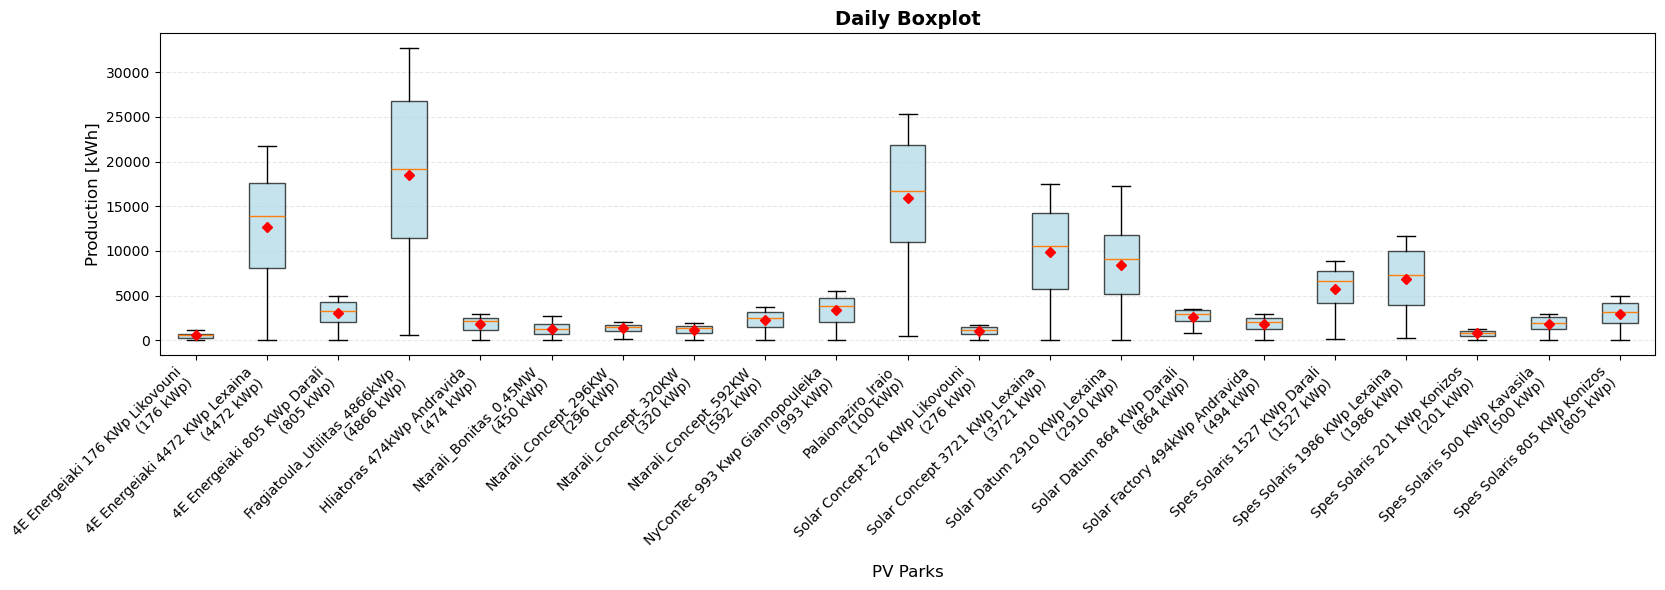

In [18]:
def plot_boxplot(
    mat: pd.DataFrame,
    title: str,
    ylabel: str = "Production [kWh]",
    ylim=None,
    save: bool = False,
    save_dir: str | Path | None = None,
    base_filename: str | None = None,
    dpi: int = 150,
    fmt: str = "png",
):
    """
    Create boxplots for each park showing the distribution of values across all dates.
    
    Parameters:
    -----------
    mat: pd.DataFrame
        Date x park dataframe with values to plot
    title: str
        Plot title
    ylabel: str
        Y-axis label (default: "Production [kWh]")
    ylim: tuple or None
        Y-axis limits as (min, max)
    save: bool
        If True, saves the figure
    save_dir: str | Path | None
        Directory where the figure will be saved. If None and `save=True`,
        pass a directory explicitly (e.g., PLOTS_DIR) or it will fallback to CWD/"plots".
    base_filename: str | None
        Base filename without extension; if None, derived from title.
    dpi: int
        Resolution for the saved image.
    fmt: str
        File format for saving (e.g., "png", "pdf", "svg").
    """
    # Prepare data - we want boxplots for each park (column)
    data_list = []
    labels = []
    
    for col in mat.columns:
        # Get non-NaN values for this park
        values = mat[col].dropna()
        if len(values) > 0:
            data_list.append(values)
            labels.append(f"{short_label(col)}\n({parse_kwp_from_header(col):.0f} kWp)")
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(max(12, 0.8 * len(labels)), 6))
    
    bp = ax.boxplot(data_list, labels=labels, patch_artist=True, showmeans=True,
                     meanprops=dict(marker='D', markerfacecolor='red', markeredgecolor='red', markersize=5))
    
    # Customize box colors
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
        patch.set_alpha(0.7)
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_xlabel("PV Parks", fontsize=12)
    
    # Rotate x labels if many parks
    if len(labels) > 10:
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    if ylim is not None:
        ax.set_ylim(ylim)
    
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    plt.tight_layout()
    
    # Use shared save utility
    saved_path = save_figure(
        fig=fig,
        title_prefix=title,
        save=save,
        save_dir=save_dir,
        base_filename=base_filename,
        dpi=dpi,
        fmt=fmt,
    )
    
    plt.show()
    
    return saved_path

plot_boxplot(daily, title="Daily Boxplot", save=False, save_dir=PLOTS_DIR, 
             base_filename="daily_boxplot", dpi=180, fmt="png")


In [19]:
def detect_outliers_iqr(df: pd.DataFrame, multiplier: float = 1.5) -> dict:
    """
    Detect outliers using the Interquartile Range (IQR) method.
    
    Parameters:
    -----------
    df: pd.DataFrame
        The dataframe to analyze
    multiplier: float
        IQR multiplier for outlier detection (default: 1.5)
        - 1.5 is standard for outliers
        - 3.0 is often used for extreme outliers
    
    Returns:
    --------
    dict with keys:
        - 'outlier_counts': Series with count of outliers per column
        - 'outlier_pcts': Series with percentage of outliers per column
        - 'outlier_mask': DataFrame with True for outliers, False otherwise
        - 'bounds': DataFrame with lower_bound and upper_bound per column
        - 'summary': DataFrame with statistics for each column
    """
    results = {
        'outlier_counts': {},
        'outlier_pcts': {},
        'outlier_mask': pd.DataFrame(index=df.index),
        'bounds': [],
        'summary': []
    }
    
    for col in df.columns:
        # Skip columns with insufficient non-NaN values
        non_nan_values = df[col].dropna()
        if len(non_nan_values) < 4:
            results['outlier_counts'][col] = 0
            results['outlier_pcts'][col] = 0.0
            results['outlier_mask'][col] = False
            results['bounds'].append({
                'column': col,
                'lower_bound': np.nan,
                'upper_bound': np.nan,
                'Q1': np.nan,
                'Q3': np.nan,
                'IQR': np.nan
            })
            continue
        
        # Calculate quartiles and IQR
        Q1 = non_nan_values.quantile(0.25)
        Q3 = non_nan_values.quantile(0.75)
        IQR = Q3 - Q1
        
        # Calculate bounds
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR
        
        # Detect outliers
        outlier_mask = (df[col] < lower_bound) | (df[col] > upper_bound)
        outlier_count = outlier_mask.sum()
        outlier_pct = (outlier_count / len(non_nan_values)) * 100 if len(non_nan_values) > 0 else 0
        
        results['outlier_counts'][col] = outlier_count
        results['outlier_pcts'][col] = outlier_pct
        results['outlier_mask'][col] = outlier_mask
        
        results['bounds'].append({
            'column': col,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound,
            'Q1': Q1,
            'Q3': Q3,
            'IQR': IQR
        })
        
        results['summary'].append({
            'column': col,
            'total_values': len(df[col]),
            'non_nan_values': len(non_nan_values),
            'outlier_count': outlier_count,
            'outlier_pct': outlier_pct,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound,
        })
    
    results['outlier_counts'] = pd.Series(results['outlier_counts'])
    results['outlier_pcts'] = pd.Series(results['outlier_pcts'])
    results['bounds'] = pd.DataFrame(results['bounds'])
    results['summary'] = pd.DataFrame(results['summary'])
    
    return results

# Detect outliers in the daily dataframe
outliers = detect_outliers_iqr(daily, multiplier=1.5)

print("=== Outlier Detection Summary (IQR method) ===")
print(f"Total columns analyzed: {len(daily.columns)}")
print(f"Columns with outliers: {(outliers['outlier_counts'] > 0).sum()}")
print(f"\nTop 10 columns with most outliers:")
top_outliers = outliers['summary'].sort_values('outlier_count', ascending=False).head(10)
print(top_outliers[['column', 'outlier_count', 'outlier_pct', 'lower_bound', 'upper_bound']].to_string(index=False))

=== Outlier Detection Summary (IQR method) ===
Total columns analyzed: 22
Columns with outliers: 0

Top 10 columns with most outliers:
                                                              column  outlier_count  outlier_pct   lower_bound  upper_bound
[4E Energeiaki 176 KWp Likovouni] PCC PCC active energy export (kWh)              0          0.0   -405.376272  1444.932544
 [4E Energeiaki 4472 KWp Lexaina] PCC PCC active energy export (kWh)              0          0.0  -6126.504225 31784.697095
   [4E Energeiaki 805 KWp Darali] PCC PCC active energy export (kWh)              0          0.0  -1358.597300  7645.945580
   [Fragiatoula_Utilitas_4866kWp] PCC PCC active energy export (kWh)              0          0.0 -11577.528500 49863.517500
     [Hliatoras 474kWp Andravida] PCC PCC active energy export (kWh)              0          0.0   -808.076835  4520.669265
         [Ntarali_Bonitas_0,45MW] PCC PCC active energy export (kWh)              0          0.0  -1045.067957  3513.8402

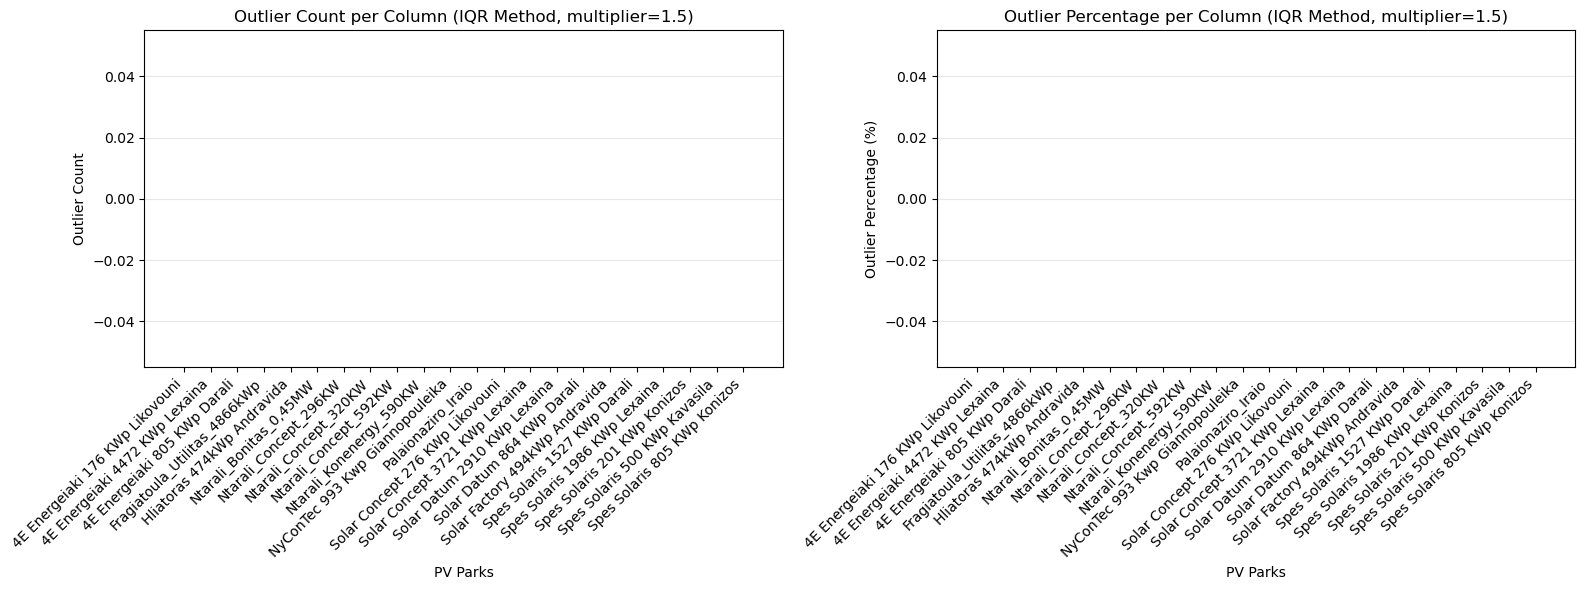

In [20]:
def visualize_outliers(outliers_result: dict, title_suffix: str = "IQR Method"):
    """
    Visualize outlier detection results with bar plots.
    
    Parameters:
    -----------
    outliers_result: dict
        Result dictionary from detect_outliers_iqr function
    title_suffix: str
        Suffix to add to plot titles (default: "IQR Method")
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Bar plot of outlier counts
    sorted_counts = outliers_result['outlier_counts'].sort_values(ascending=False)
    ax1.bar(range(len(sorted_counts)), sorted_counts.values, color='crimson', alpha=0.7)
    ax1.set_xticks(range(len(sorted_counts)))
    ax1.set_xticklabels([short_label(col) for col in sorted_counts.index], rotation=45, ha='right')
    ax1.set_ylabel("Outlier Count")
    ax1.set_xlabel("PV Parks")
    ax1.set_title(f"Outlier Count per Column ({title_suffix})")
    ax1.grid(axis='y', alpha=0.3)
    
    # Bar plot of outlier percentages
    sorted_pcts = outliers_result['outlier_pcts'].sort_values(ascending=False)
    ax2.bar(range(len(sorted_pcts)), sorted_pcts.values, color='orange', alpha=0.7)
    ax2.set_xticks(range(len(sorted_pcts)))
    ax2.set_xticklabels([short_label(col) for col in sorted_pcts.index], rotation=45, ha='right')
    ax2.set_ylabel("Outlier Percentage (%)")
    ax2.set_xlabel("PV Parks")
    ax2.set_title(f"Outlier Percentage per Column ({title_suffix})")
    ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Visualize the outliers
visualize_outliers(outliers, title_suffix="IQR Method, multiplier=1.5")


In [36]:
# CREATE METADATA WITH ACTUAL COORDINATES
# Replace this cell with your actual park metadata
# Expected columns: park_name, lat, lon, kwp, loss_pct, timezone

# OPTION 1: Load from CSV file with actual coordinates
# meta = pd.read_csv(WORKSPACE_ROOT / "data" / "park_metadata.csv")
# Required columns: park_name (matching park_cols), lat, lon, kwp, loss_pct, timezone

# OPTION 2: Create manually for each park
# Example structure:
meta_data = {
    'park_name': park_cols,
    'latitude': [
    38.39,
    37.61,
    38.31,
    38.10,
    37.94,
    38.31,
    38.31,
    38.31,
    38.31,
    38.31,
    38.02,
    37.95,
    38.39,
    37.94,
    37.95,
    38.31,
    37.94,
    38.30,
    37.95,
    38.29,
    37.89,
    38.30
],  # REPLACE with actual latitudes
    'longitude': [
    23.47,
    21.89,
    23.24,
    21.65,
    21.30,
    23.24,
    23.24,
    23.24,
    23.24,
    23.24,
    21.40,
    21.29,
    23.47,
    21.30,
    21.29,
    23.24,
    21.30,
    23.24,
    21.29,
    23.29,
    21.27,
    23.28
],  # REPLACE with actual longitudes
    'kwp': [parse_kwp_from_header(col) for col in park_cols],  # Extracted from column names
    'loss_pct': [18.0] * len(park_cols),  # System losses (adjust per park if needed)
    'timezone': ['Europe/Athens'] * len(park_cols)
}
meta = pd.DataFrame(meta_data)

# Validate metadata
print(f"Metadata created for {len(meta)} parks")
print(f"Park columns count: {len(park_cols)}")
print(f"\nValidation:")
print(f"  - Latitudes: {len(meta['latitude'])} values")
print(f"  - Longitudes: {len(meta['longitude'])} values")
print(f"  - All parks matched: {len(meta) == len(park_cols)}")

# Check if all park names match
if set(meta['park_name']) != set(park_cols):
    missing_in_meta = set(park_cols) - set(meta['park_name'])
    extra_in_meta = set(meta['park_name']) - set(park_cols)
    if missing_in_meta:
        print(f"\n⚠️  WARNING: Parks missing in metadata: {len(missing_in_meta)}")
        print(f"   First few: {list(missing_in_meta)[:3]}")
    if extra_in_meta:
        print(f"\n⚠️  WARNING: Extra parks in metadata: {len(extra_in_meta)}")
else:
    print(f"  ✓ All park names match!")

meta.set_index('park_name', inplace=True)

print(f"\nSample metadata:")
print(meta.head(10))
print(f"\n✓ Using actual coordinates from Greece")


Metadata created for 22 parks
Park columns count: 22

Validation:
  - Latitudes: 22 values
  - Longitudes: 22 values
  - All parks matched: True
  ✓ All park names match!

Sample metadata:
                                                    latitude  longitude  \
park_name                                                                 
[4E Energeiaki 176 KWp Likovouni] PCC PCC activ...     38.39      23.47   
[4E Energeiaki 4472 KWp Lexaina] PCC PCC active...     37.61      21.89   
[4E Energeiaki 805 KWp Darali] PCC PCC active e...     38.31      23.24   
[Fragiatoula_Utilitas_4866kWp] PCC PCC active e...     38.10      21.65   
[Hliatoras 474kWp Andravida] PCC PCC active ene...     37.94      21.30   
[Ntarali_Bonitas_0,45MW] PCC PCC active energy ...     38.31      23.24   
[Ntarali_Concept_296KW] PCC PCC active energy e...     38.31      23.24   
[Ntarali_Concept_320KW] PCC PCC active energy e...     38.31      23.24   
[Ntarali_Concept_592KW] PCC PCC active energy e...     38.31 

In [37]:
# Reload the module to pick up the fix
importlib.reload(pvgis_pi_heatmap)
from src.pvgis_pi_heatmap import compute_pi_anomaly

# Recompute with the fixed function
pi_fixed, score_fixed, flag_fixed = compute_pi_anomaly(
    daily_df=daily,
    meta=meta,
    cache_dir=CACHE_DIR,
    pvgis_url="https://re.jrc.ec.europa.eu/api/",
)

print("\nFixed PI data info:")
print(f"  Total rows: {len(pi_fixed)}")
print(f"  Non-NaN rows: {pi_fixed.notna().any(axis=1).sum()}")
print(f"  First non-NaN date: {pi_fixed[pi_fixed.notna().any(axis=1)].index.min() if pi_fixed.notna().any(axis=1).any() else 'None'}")
print(f"  Last non-NaN date: {pi_fixed[pi_fixed.notna().any(axis=1)].index.max() if pi_fixed.notna().any(axis=1).any() else 'None'}")
print(f"\nData after 2024-12-31:")
pi_2025plus = pi_fixed[pi_fixed.index > '2024-12-31']
print(f"  Rows: {len(pi_2025plus)}")
print(f"  Non-NaN values: {pi_2025plus.notna().sum().sum()}")

# Update the main variables
pi = pi_fixed
score = score_fixed
flag = flag_fixed

PVGIS per park: 100%|██████████| 22/22 [00:50<00:00,  2.28s/it]


Fixed PI data info:
  Total rows: 377
  Non-NaN rows: 376
  First non-NaN date: 2025-01-02 00:00:00
  Last non-NaN date: 2026-01-12 00:00:00

Data after 2024-12-31:
  Rows: 377
  Non-NaN values: 6394


In [38]:
print("Daily data date range:")
print(f"  Start: {daily.index.min()}")
print(f"  End: {daily.index.max()}")
print(f"  Years: {daily.index.min().year} to {daily.index.max().year}")
print(f"\nPI data info:")
print(f"  Total rows: {len(pi)}")
print(f"  Non-NaN rows: {pi.notna().any(axis=1).sum()}")
print(f"  First non-NaN date: {pi[pi.notna().any(axis=1)].index.min() if pi.notna().any(axis=1).any() else 'None'}")
print(f"  Last non-NaN date: {pi[pi.notna().any(axis=1)].index.max() if pi.notna().any(axis=1).any() else 'None'}")
print(f"\nData after 2024-01-01:")
pi_2024plus = pi[pi.index >= '2024-01-01']
print(f"  Rows: {len(pi_2024plus)}")
print(f"  Non-NaN values: {pi_2024plus.notna().sum().sum()}")

Daily data date range:
  Start: 2025-01-01 00:00:00
  End: 2026-01-12 00:00:00
  Years: 2025 to 2026

PI data info:
  Total rows: 377
  Non-NaN rows: 376
  First non-NaN date: 2025-01-02 00:00:00
  Last non-NaN date: 2026-01-12 00:00:00

Data after 2024-01-01:
  Rows: 377
  Non-NaN values: 6394


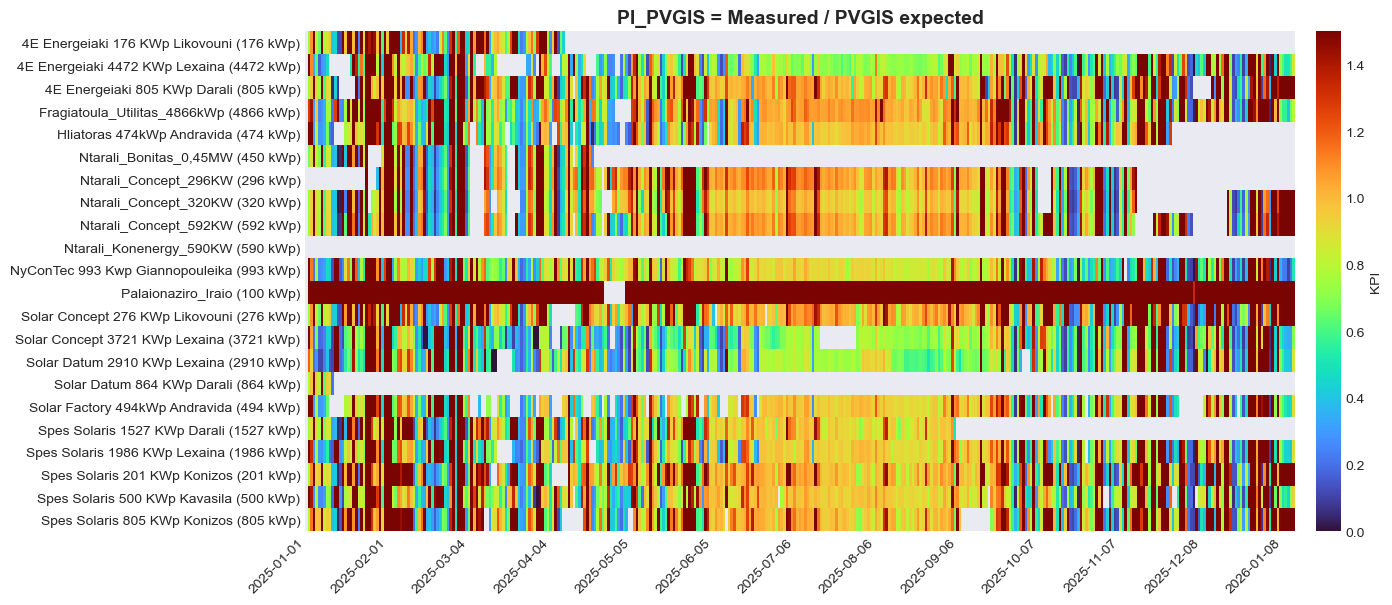

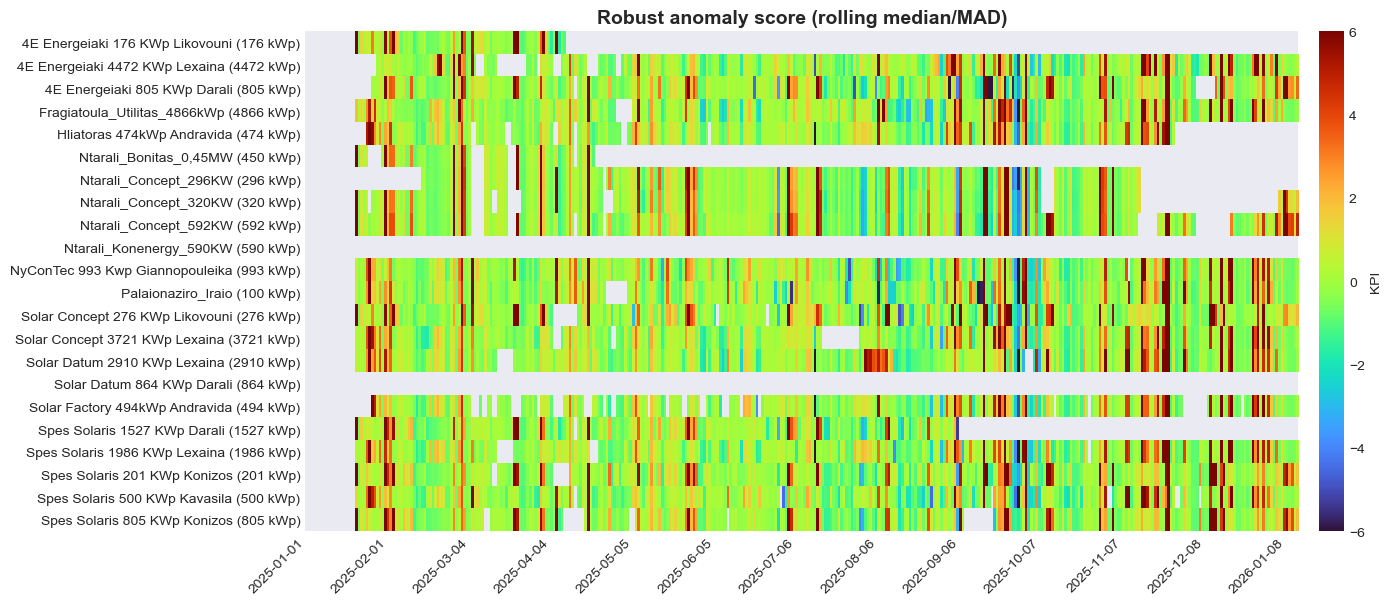

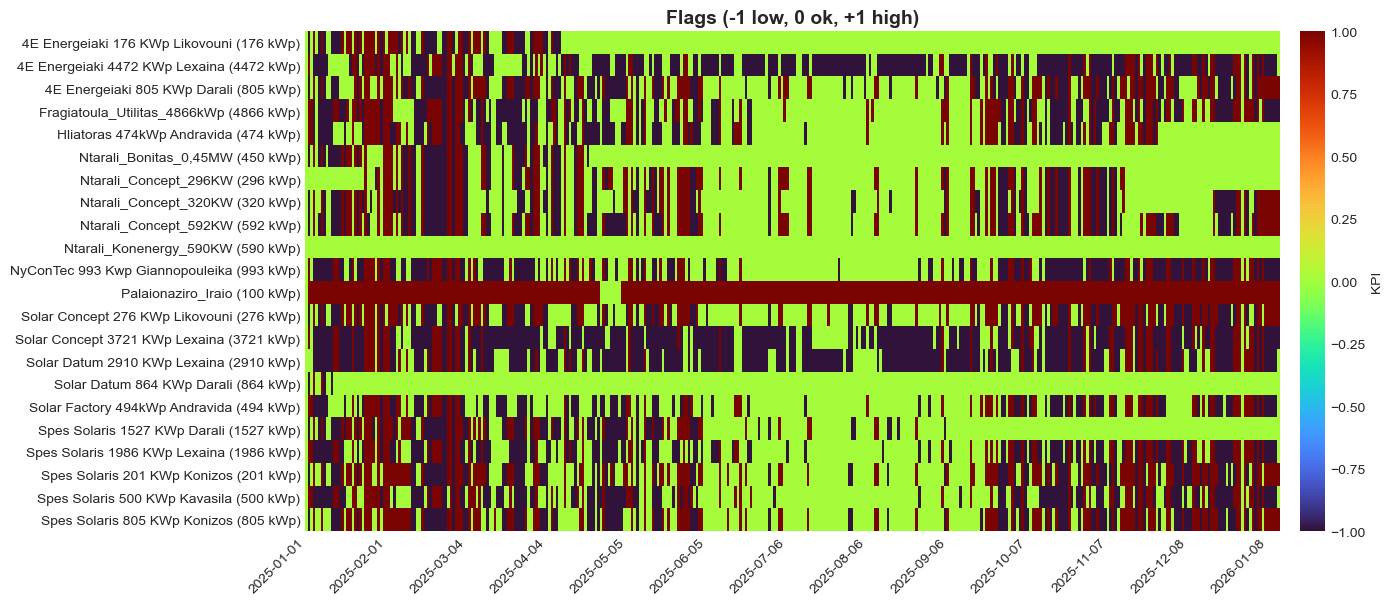

In [47]:
def plot_heatmap(
    mat: pd.DataFrame,
    title: str,
    vmin=None,
    vmax=None,
    start_date=None,
    end_date=None,
    save: bool = False,
    save_dir: str | Path | None = None,
    base_filename: str | None = None,
    dpi: int = 150,
    fmt: str = "png",
):
    """
    Plot a heatmap of date x park data.
    
    Parameters:
    -----------
    mat: pd.DataFrame
        Date x park dataframe with values to plot
    title: str
        Plot title
    vmin: float or None
        Minimum value for colormap
    vmax: float or None
        Maximum value for colormap
    start_date: str or pd.Timestamp or None
        Start date for filtering (inclusive). Format: 'YYYY-MM-DD' or any pandas-compatible date
    end_date: str or pd.Timestamp or None
        End date for filtering (inclusive). Format: 'YYYY-MM-DD' or any pandas-compatible date
    save: bool
        If True, saves the figure
    save_dir: str | Path | None
        Directory where the figure will be saved. If None and `save=True`,
        pass a directory explicitly (e.g., PLOTS_DIR) or it will fallback to CWD/"plots".
    base_filename: str | None
        Base filename without extension; if None, derived from title.
    dpi: int
        Resolution for the saved image.
    fmt: str
        File format for saving (e.g., "png", "pdf", "svg").
    """
    # Filter by date range if specified
    if start_date is not None or end_date is not None:
        if start_date is not None:
            start_date = pd.to_datetime(start_date)
            mat = mat[mat.index >= start_date]
        if end_date is not None:
            end_date = pd.to_datetime(end_date)
            mat = mat[mat.index <= end_date]
        
        if len(mat) == 0:
            print(f"Warning: No data found in the specified date range")
            return None
    
    # mat: date x park -> we plot parks x dates
    m = mat.T.copy()

    # nicer y labels (park label + kWp)
    y = []
    for col in m.index:
        y.append(f"{short_label(col)} ({parse_kwp_from_header(col):.0f} kWp)")
    m.index = y

    fig, ax = plt.subplots(figsize=(14, max(6, 0.28 * len(m.index))))
    im = ax.imshow(m.values, aspect="auto", interpolation="nearest", cmap="turbo", vmin=vmin, vmax=vmax)

    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_yticks(np.arange(len(m.index)))
    ax.set_yticklabels(m.index, fontsize=10)

    dates = pd.to_datetime(m.columns)
    step = max(1, len(dates) // 12)
    xticks = np.arange(0, len(dates), step)
    ax.set_xticks(xticks)
    ax.set_xticklabels([d.strftime("%Y-%m-%d") for d in dates[::step]], rotation=45, ha="right")

    # Disable grid lines (they can appear as lines over the heatmap)
    ax.grid(False)

    cbar = plt.colorbar(im, ax=ax, fraction=0.025, pad=0.02)
    cbar.ax.set_ylabel("KPI", rotation=90, fontsize=10)
    plt.tight_layout()
    
    # Use shared save utility
    saved_path = save_figure(
        fig=fig,
        title_prefix=title,
        save=save,
        save_dir=save_dir,
        base_filename=base_filename,
        dpi=dpi,
        fmt=fmt,
    )
    
    plt.show()
    
    return saved_path

# Examples showing KPI data
plot_heatmap(pi, "PI_PVGIS = Measured / PVGIS expected", vmin=0.0, vmax=1.5,
             save=True, save_dir=PLOTS_DIR, base_filename="heatmap_pi", dpi=180, fmt="png")
plot_heatmap(score, "Robust anomaly score (rolling median/MAD)", vmin=-6, vmax=6,
             save=False, save_dir=PLOTS_DIR, base_filename="heatmap_score", dpi=180, fmt="png")
plot_heatmap(flag, "Flags (-1 low, 0 ok, +1 high)", vmin=-1, vmax=1,
             save=False, save_dir=PLOTS_DIR, base_filename="heatmap_flag", dpi=180, fmt="png")


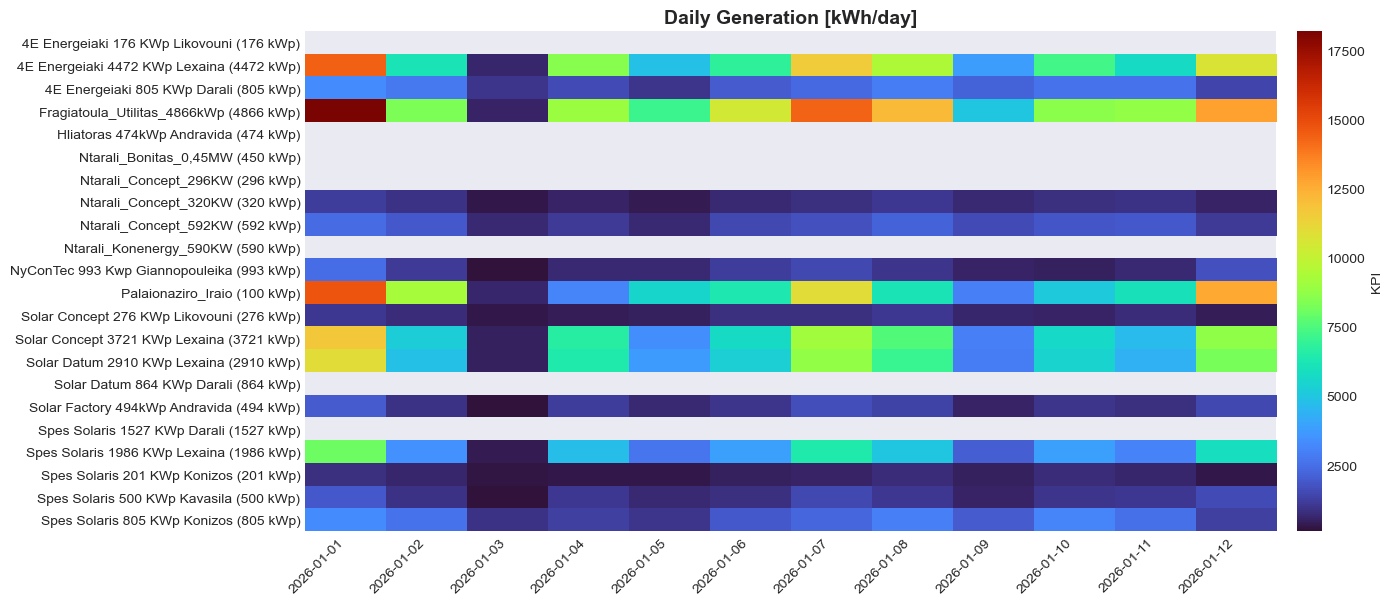

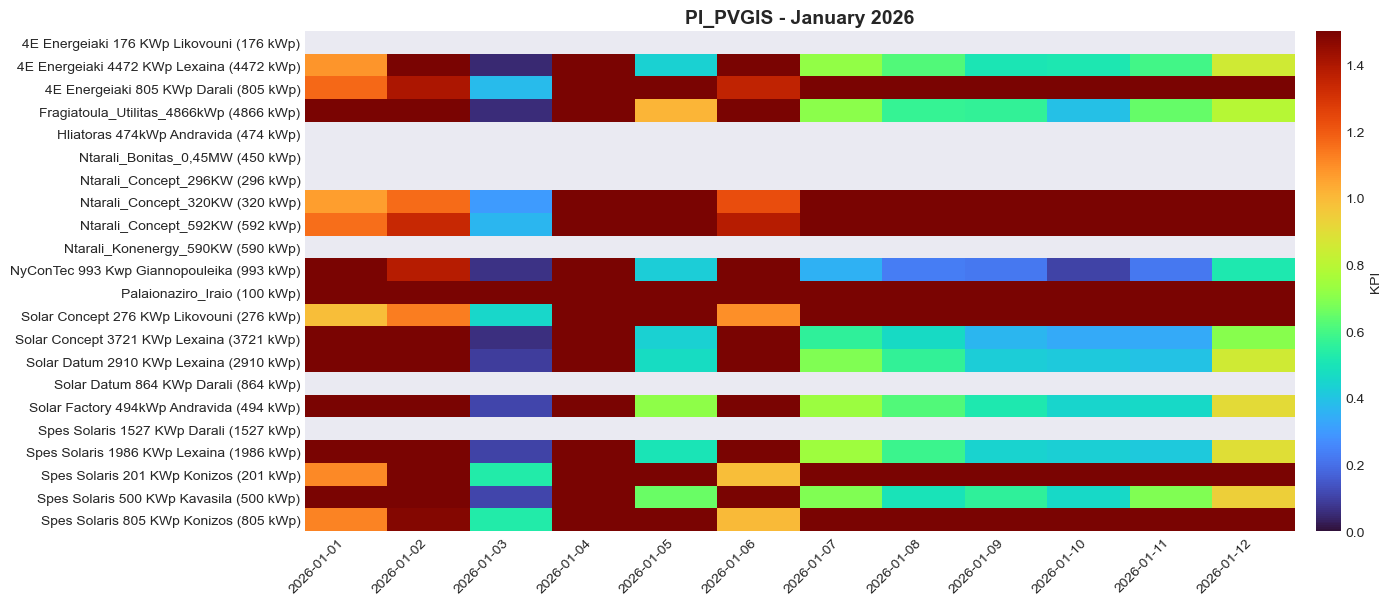

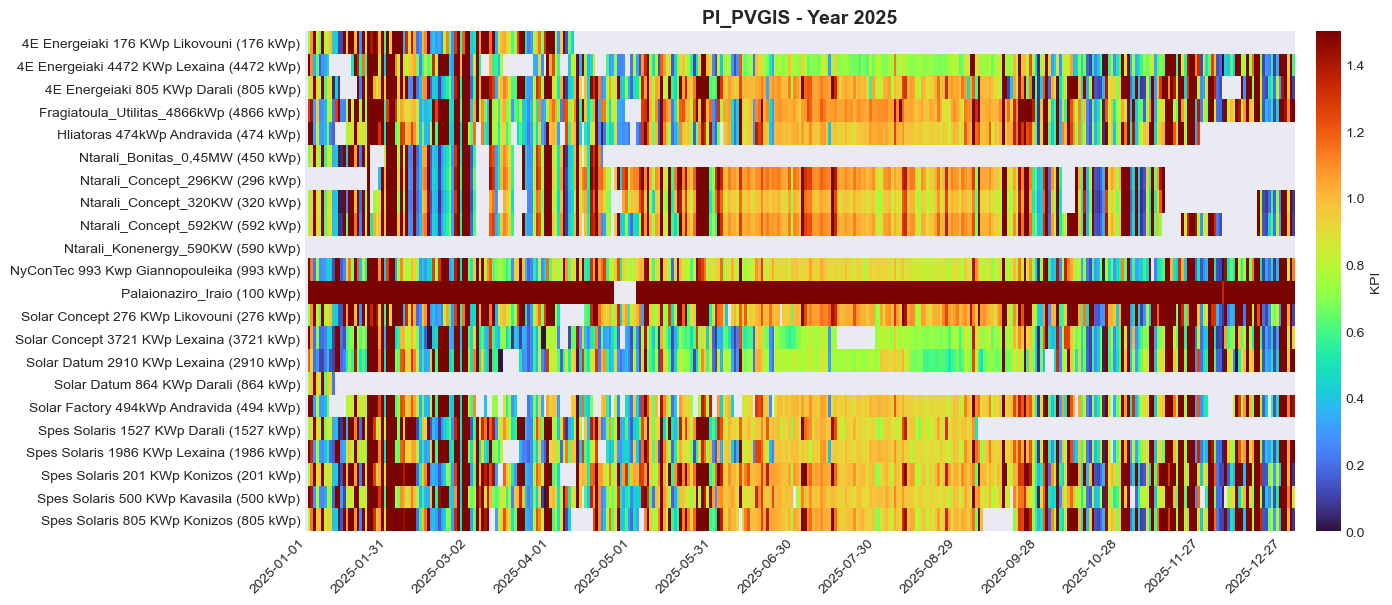

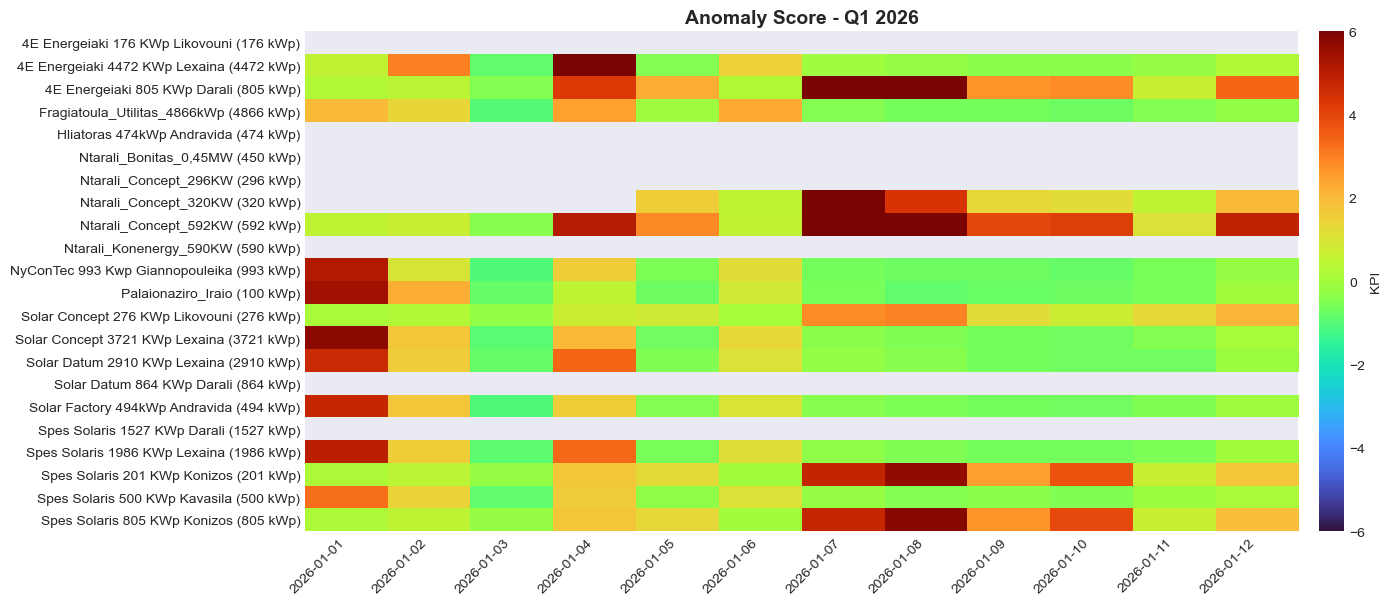

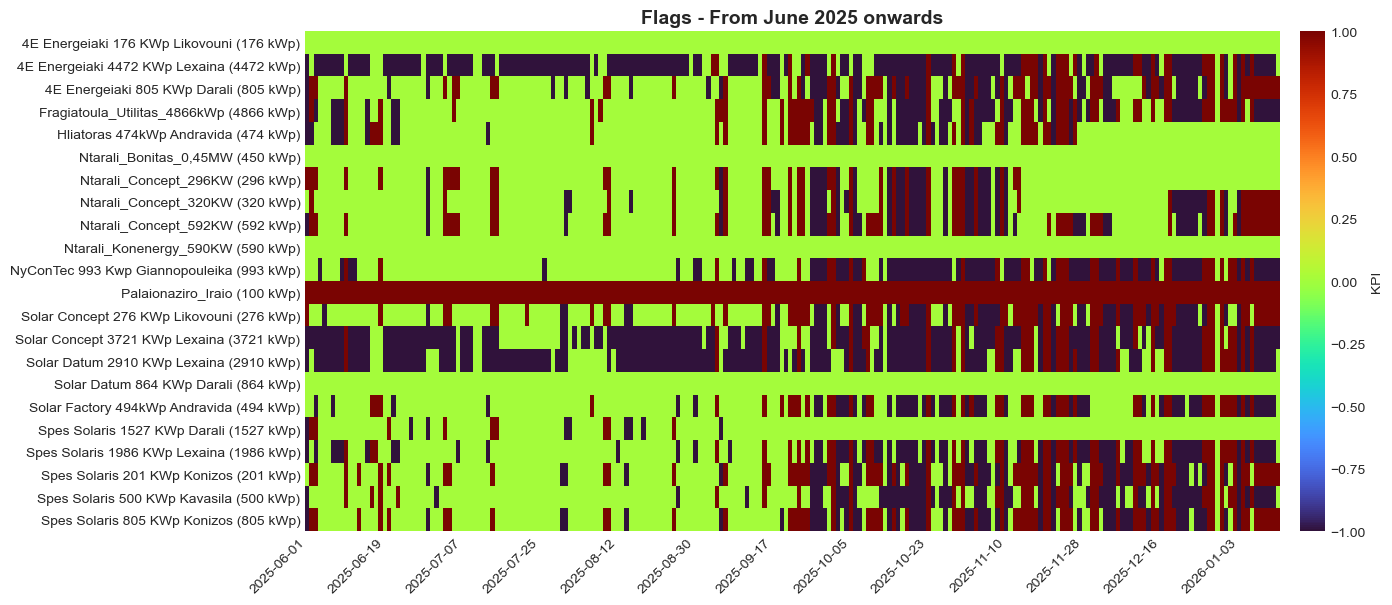

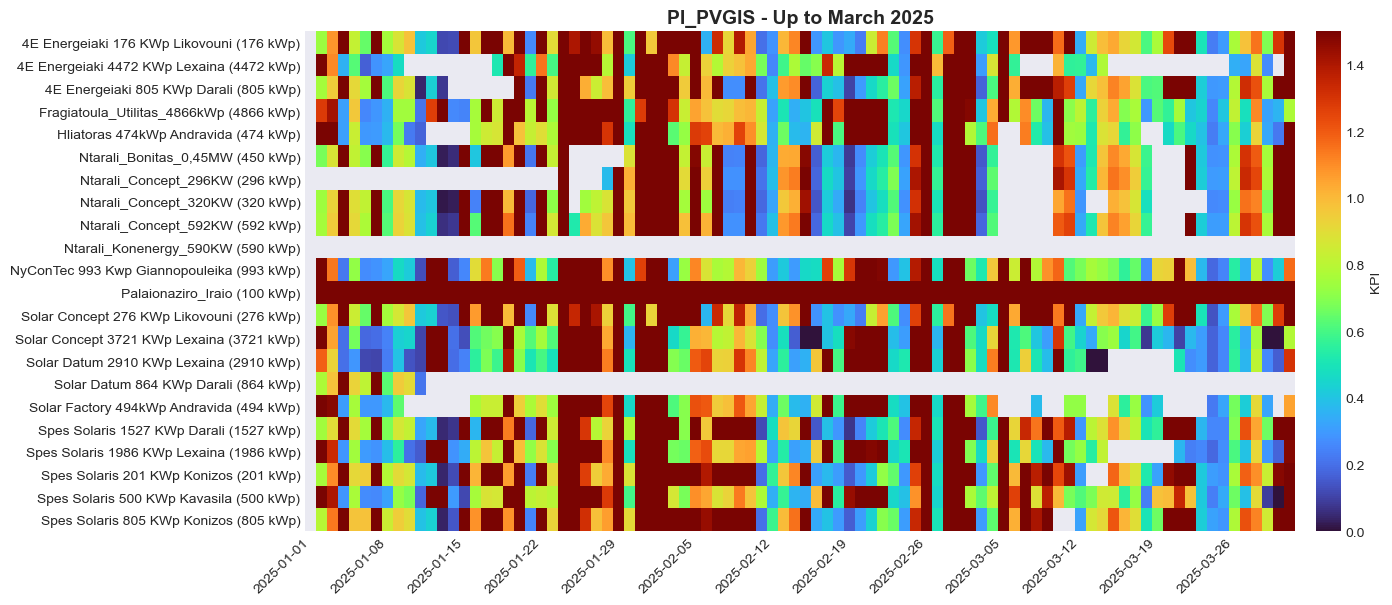

In [48]:
# Plot actual generation data with date filtering
plot_heatmap(daily, "Daily Generation [kWh/day]", vmin=None, vmax=None,
             start_date='2026-01-01', end_date='2026-01-31',
             save=False, save_dir=PLOTS_DIR, base_filename="heatmap_daily_jan2026", dpi=180, fmt="png")

# Example: Filter heatmap to show only specific date ranges
# Show only January 2026
plot_heatmap(pi, "PI_PVGIS - January 2026", vmin=0.0, vmax=1.5, 
             start_date='2026-01-01', end_date='2026-01-31',
             save=True, save_dir=PLOTS_DIR, base_filename="heatmap_pi_jan2026", dpi=180, fmt="png")

# Show only 2025 data
plot_heatmap(pi, "PI_PVGIS - Year 2025", vmin=0.0, vmax=1.5, 
             start_date='2025-01-01', end_date='2025-12-31',
             save=False, save_dir=PLOTS_DIR, base_filename="heatmap_pi_2025", dpi=180, fmt="png")

# Show Q1 2026
plot_heatmap(score, "Anomaly Score - Q1 2026", vmin=-6, vmax=6,
             start_date='2026-01-01', end_date='2026-01-15',
             save=False, save_dir=PLOTS_DIR, base_filename="heatmap_score_q1_2026", dpi=180, fmt="png")

# Show data from a specific date onwards
plot_heatmap(flag, "Flags - From June 2025 onwards", vmin=-1, vmax=1,
             start_date='2025-06-01',
             save=False, save_dir=PLOTS_DIR, base_filename="heatmap_flag_from_jun2025", dpi=180, fmt="png")

# Show data up to a specific date
plot_heatmap(pi, "PI_PVGIS - Up to March 2025", vmin=0.0, vmax=1.5,
             end_date='2025-03-31',
             save=False, save_dir=PLOTS_DIR, base_filename="heatmap_pi_until_mar2025", dpi=180, fmt="png")


In [50]:
DATA_XLSX_HISTORICAL = DATA_DIR / "daily_energy_historical.xlsx"

df_historical = pd.read_excel(DATA_XLSX_HISTORICAL)

# Expect Timestamp column exactly
df_historical["Timestamp"] = pd.to_datetime(df_historical["Timestamp"])
df_historical["date"] = df_historical["Timestamp"].dt.normalize()

_park_cols = [c for c in df_historical.columns if c not in ["Timestamp", "date"]]
daily_historical = df_historical.set_index("date")[_park_cols].sort_index()

daily_historical.head()

,[4E Energeiaki 176 KWp Likovouni] PCC PCC active energy export (kWh),[4E Energeiaki 4472 KWp Lexaina] PCC PCC active energy export (kWh),[4E Energeiaki 805 KWp Darali] PCC PCC active energy export (kWh),[Fragiatoula_Utilitas_4866kWp] PCC PCC active energy export (kWh),[Hliatoras 474kWp Andravida] PCC PCC active energy export (kWh),"[Ntarali_Bonitas_0,45MW] PCC PCC active energy export (kWh)",[Ntarali_Concept_296KW] PCC PCC active energy export (kWh),[Ntarali_Concept_320KW] PCC PCC active energy export (kWh),[Ntarali_Concept_592KW] PCC PCC active energy export (kWh),[Ntarali_Konenergy_590KW] PCC PCC active energy export (kWh),...,[Solar Concept 276 KWp Likovouni] PCC PCC active energy export (kWh),[Solar Concept 3721 KWp Lexaina] PCC PCC active energy export (kWh),[Solar Datum 2910 KWp Lexaina] PCC PCC active energy export (kWh),[Solar Datum 864 KWp Darali] PCC PCC active energy export (kWh),[Solar Factory 494kWp Andravida] PCC PCC active energy export (kWh),[Spes Solaris 1527 KWp Darali] PCC PCC active energy export (kWh),[Spes Solaris 1986 KWp Lexaina] PCC PCC active energy export (kWh),[Spes Solaris 201 KWp Konizos] PCC PCC active energy export (kWh),[Spes Solaris 500 KWp Kavasila] PCC PCC active energy export (kWh),[Spes Solaris 805 KWp Konizos] PCC PCC active energy export (kWh)
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,NaN,14670.64220,NaN,NaN,1730.993420,517.046106,NaN,NaN,644.558326,NaN,...,332.224879,12044.34670,10413.09050,0.000000,1792.119800,2431.834720,7088.51379,250.291935,1661.696670,1196.693600
2020-01-02,NaN,17252.53530,NaN,NaN,2028.838680,497.254069,NaN,NaN,585.107412,NaN,...,189.126976,14186.72390,12128.32300,0.000000,2090.105090,1801.699530,8259.60731,243.756435,1753.937790,1070.945850
2020-01-03,NaN,15309.77260,1650.028320,NaN,2043.893020,977.709693,NaN,NaN,1268.503910,NaN,...,686.684991,14322.25310,11380.64210,0.000000,2118.331550,3177.581970,7976.55164,406.550516,844.553758,1847.116490
2020-01-04,NaN,16125.67710,3311.980580,NaN,1928.637490,1625.531200,NaN,NaN,2302.234370,NaN,...,1211.142210,13047.52420,11520.54270,0.000000,2000.069500,5828.960420,7871.09523,758.458963,1757.029160,3249.431960
2020-01-05,NaN,5728.02507,436.092801,NaN,699.792991,404.281101,NaN,NaN,570.376910,NaN,...,288.899236,4671.14395,4047.98586,70.066733,708.998928,933.315626,2767.52972,225.726567,661.754172,919.416618


In [51]:
def analyze_month_to_date_by_year(
    df: pd.DataFrame,
    column: str,
    aggregation: str = 'sum',
    current_date: pd.Timestamp | str | None = None,
) -> pd.Series | list:
    """
    Analyze month-to-date values for a specific column across all years in the dataset.
    
    For the current month (e.g., January 16), this function extracts data from the 
    start of the month (Jan 1) to the current day (Jan 16) for each year in the dataset
    and aggregates it according to the specified method.
    
    Parameters:
    -----------
    df: pd.DataFrame
        Date-indexed DataFrame with columns representing different series/parks
    column: str
        Column name to analyze. If not found, returns list of available columns
    aggregation: str
        Aggregation method: 'sum', 'mean', 'avg', 'min', 'max', 'median', 'std', 'count'
        Default: 'sum'
    current_date: pd.Timestamp | str | None
        Reference date (defaults to today). Used to determine which month and day-of-month
        to analyze across all years
    
    Returns:
    --------
    pd.Series with year as index and aggregated values, or list of columns if column not found
    
    Example:
    --------
    # Analyze January 1-16 energy generation (sum) for each year
    result = analyze_month_to_date_by_year(daily_historical, 'Park A [100 kWp]', 'sum')
    
    # Analyze January 1-16 average generation for each year  
    result = analyze_month_to_date_by_year(daily_historical, 'Park B [200 kWp]', 'mean')
    """
    # Check if column exists
    if column not in df.columns:
        print(f"❌ Column '{column}' not found in dataframe")
        print(f"\n📋 Available columns ({len(df.columns)}):")
        return list(df.columns)
    
    # Set current date (default to today)
    if current_date is None:
        current_date = pd.Timestamp.now()
    else:
        current_date = pd.to_datetime(current_date)
    
    # Extract current month and day
    current_month = current_date.month
    current_day = current_date.day
    
    # Map aggregation aliases
    agg_map = {
        'avg': 'mean',
        'average': 'mean',
    }
    aggregation = agg_map.get(aggregation.lower(), aggregation.lower())
    
    # Validate aggregation method
    valid_aggs = ['sum', 'mean', 'min', 'max', 'median', 'std', 'count']
    if aggregation not in valid_aggs:
        raise ValueError(f"Invalid aggregation '{aggregation}'. Valid options: {valid_aggs}")
    
    # Get all unique years in the dataset
    years = df.index.year.unique()
    
    results = {}
    
    for year in sorted(years):
        # Create date range for this year (month-to-date)
        start_date = pd.Timestamp(year=year, month=current_month, day=1)
        end_date = pd.Timestamp(year=year, month=current_month, day=current_day)
        
        # Check if this date range exists for this year
        if end_date > df.index.max() or start_date < df.index.min():
            # Skip years where the date range doesn't exist
            continue
        
        # Filter data for this period
        mask = (df.index >= start_date) & (df.index <= end_date)
        period_data = df.loc[mask, column].dropna()
        
        # Skip if no data for this period
        if len(period_data) == 0:
            continue
        
        # Apply aggregation
        if aggregation == 'sum':
            value = period_data.sum()
        elif aggregation == 'mean':
            value = period_data.mean()
        elif aggregation == 'min':
            value = period_data.min()
        elif aggregation == 'max':
            value = period_data.max()
        elif aggregation == 'median':
            value = period_data.median()
        elif aggregation == 'std':
            value = period_data.std()
        elif aggregation == 'count':
            value = period_data.count()
        
        results[year] = value
    
    # Create result series
    result = pd.Series(results, name=f'{aggregation.capitalize()}')
    result.index.name = 'Year'
    
    # Print summary
    month_name = current_date.strftime('%B')
    print(f"\n📊 Analysis: {month_name} 1-{current_day} ({aggregation}) for '{short_label(column)}'")
    print(f"   Column: {column}")
    print(f"   Years analyzed: {len(result)}")
    print(f"   Date range per year: {month_name} 1 - {month_name} {current_day}")
    print(f"\n{result.to_string()}")
    
    return result


# Example usage
print("="*80)
print("MONTH-TO-DATE ANALYSIS ACROSS YEARS")
print("="*80)

# Test: If column doesn't exist, it returns the column list
print("\n1. Testing with invalid column:")
columns_list = analyze_month_to_date_by_year(daily_historical, 'NonExistent Column', 'sum')

# Test: Analyze January 1-16 sum for the first park
if len(daily_historical.columns) > 0:
    print("\n2. Analyzing first park (sum):")
    first_park = daily_historical.columns[0]
    jan_sum = analyze_month_to_date_by_year(daily_historical, first_park, 'sum')
    
    print("\n3. Analyzing first park (mean):")
    jan_mean = analyze_month_to_date_by_year(daily_historical, first_park, 'mean')
    
    print("\n4. Analyzing first park (max):")
    jan_max = analyze_month_to_date_by_year(daily_historical, first_park, 'max')


MONTH-TO-DATE ANALYSIS ACROSS YEARS

1. Testing with invalid column:
❌ Column 'NonExistent Column' not found in dataframe

📋 Available columns (22):

2. Analyzing first park (sum):

📊 Analysis: January 1-16 (sum) for '4E Energeiaki 176 KWp Likovouni'
   Column: [4E Energeiaki 176 KWp Likovouni] PCC PCC active energy export (kWh)
   Years analyzed: 6
   Date range per year: January 1 - January 16

Year
2020    4638.572081
2021    6786.243514
2022    5907.759051
2023    9450.637713
2024    6780.367047
2025    6341.996268

3. Analyzing first park (mean):

📊 Analysis: January 1-16 (mean) for '4E Energeiaki 176 KWp Likovouni'
   Column: [4E Energeiaki 176 KWp Likovouni] PCC PCC active energy export (kWh)
   Years analyzed: 6
   Date range per year: January 1 - January 16

Year
2020    421.688371
2021    424.140220
2022    492.313254
2023    590.664857
2024    423.772940
2025    396.374767

4. Analyzing first park (max):

📊 Analysis: January 1-16 (max) for '4E Energeiaki 176 KWp Likovouni'
 

In [57]:
def calculate_revenue_from_energy(
    energy_sum: pd.Series,
    price_per_kwh: float = 0.2,
    currency: str = "EUR",
) -> pd.Series:
    """
    Calculate revenue from energy generation values.
    
    Parameters:
    -----------
    energy_sum: pd.Series
        Series with energy values (kWh) indexed by year
    price_per_kwh: float
        Price per kWh in the specified currency (default: 0.2)
    currency: str
        Currency code for display (default: "EUR")
    
    Returns:
    --------
    pd.Series with revenue values indexed by year
    
    Example:
    --------
    # Get month-to-date energy sum for each year
    energy = analyze_month_to_date_by_year(daily_historical, 'Park A [100 kWp]', 'sum')
    
    # Calculate revenue at 0.2 EUR/kWh
    revenue = calculate_revenue_from_energy(energy, price_per_kwh=0.2)
    """
    revenue = energy_sum * price_per_kwh
    revenue.name = f'Revenue ({currency})'
    
    # Print summary
    print(f"\n💰 Revenue Calculation")
    print(f"   Price: {price_per_kwh:.4f} {currency}/kWh")
    print(f"   Years: {len(revenue)}")
    print(f"\n{revenue.to_string()}")
    print(f"\n   Total revenue: {revenue.sum():,.2f} {currency}")
    print(f"   Average revenue/year: {revenue.mean():,.2f} {currency}")
    print(f"   Min revenue: {revenue.min():,.2f} {currency} (Year {revenue.idxmin()})")
    print(f"   Max revenue: {revenue.max():,.2f} {currency} (Year {revenue.idxmax()})")
    
    return revenue


# Example usage
print("\n" + "="*80)
print("REVENUE ANALYSIS")
print("="*80)

if len(daily_historical.columns) > 0:
    first_park = daily_historical.columns[0]
    
    # Get January 1-16 energy sum for each year
    print("\n1. Getting month-to-date energy data:")
    jan_energy = analyze_month_to_date_by_year(daily_historical, first_park, 'sum')
    
    # Calculate revenue at default price (0.2 EUR/kWh)
    print("\n2. Calculating revenue at 0.2 EUR/kWh:")
    revenue_default = calculate_revenue_from_energy(jan_energy, price_per_kwh=0.2)



REVENUE ANALYSIS

1. Getting month-to-date energy data:

📊 Analysis: January 1-16 (sum) for '4E Energeiaki 176 KWp Likovouni'
   Column: [4E Energeiaki 176 KWp Likovouni] PCC PCC active energy export (kWh)
   Years analyzed: 6
   Date range per year: January 1 - January 16

Year
2020    4638.572081
2021    6786.243514
2022    5907.759051
2023    9450.637713
2024    6780.367047
2025    6341.996268

2. Calculating revenue at 0.2 EUR/kWh:

💰 Revenue Calculation
   Price: 0.2000 EUR/kWh
   Years: 6

Year
2020     927.714416
2021    1357.248703
2022    1181.551810
2023    1890.127543
2024    1356.073409
2025    1268.399254

   Total revenue: 7,981.12 EUR
   Average revenue/year: 1,330.19 EUR
   Min revenue: 927.71 EUR (Year 2020)
   Max revenue: 1,890.13 EUR (Year 2023)


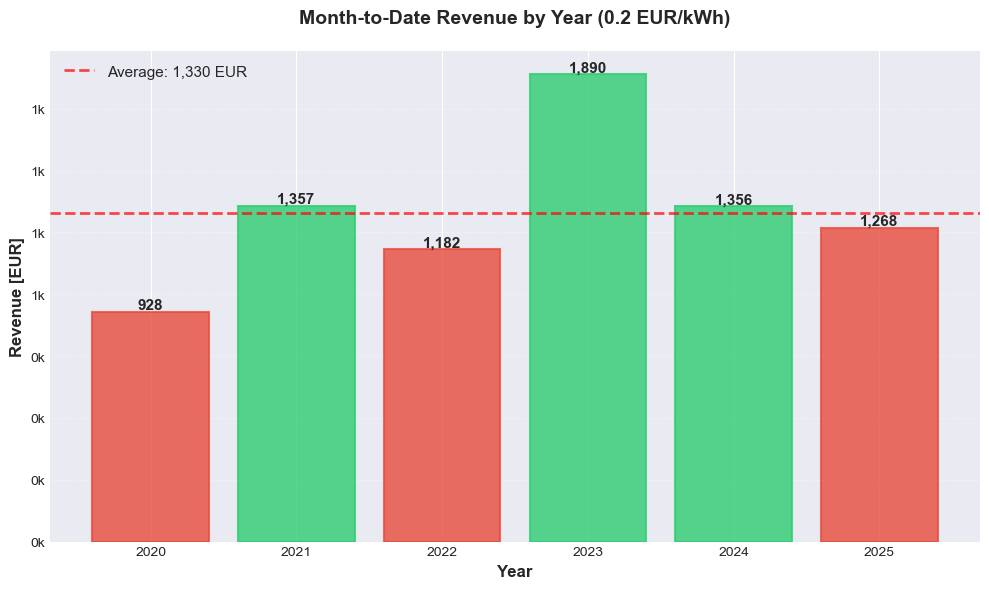


REVENUE DEFAULT SUMMARY

Year
2020     927.714416
2021    1357.248703
2022    1181.551810
2023    1890.127543
2024    1356.073409
2025    1268.399254

Total:                  7,981.12 EUR
Average:                1,330.19 EUR
Median:                 1,312.24 EUR
Min (Year 2020):                 927.71 EUR
Max (Year 2023):               1,890.13 EUR
Std Deviation:            317.12 EUR


In [ ]:
def plot_revenue_by_year(
    revenue_series: pd.Series,
    title: str = "Month-to-Date Revenue by Year",
    price_per_kwh: float = 0.2,
    currency: str = "EUR",
    save: bool = False,
    save_dir: str | Path | None = None,
    base_filename: str | None = None,
    dpi: int = 150,
    fmt: str = "png",
):
    """
    Create an appealing bar chart visualization of revenue by year.
    
    Parameters:
    -----------
    revenue_series: pd.Series
        Series with revenue values indexed by year
    title: str
        Chart title
    price_per_kwh: float
        Price per kWh (for display purposes)
    currency: str
        Currency code for display (default: "EUR")
    save: bool
        If True, saves the figure
    save_dir: str | Path | None
        Directory where the figure will be saved
    base_filename: str | None
        Base filename without extension; if None, derived from title
    dpi: int
        Resolution for the saved image
    fmt: str
        File format for saving
    
    Returns:
    --------
    Tuple of (fig, saved_path)
    """
    fig, ax = plt.subplots(figsize=(12, 7), facecolor='white')
    
    # Calculate average and statistics
    avg_revenue = revenue_series.mean()
    
    # Create color list - gradient effect with conditional coloring
    colors = []
    for value in revenue_series.values:
        if value >= avg_revenue * 1.1:
            colors.append('#27ae60')  # Dark green - well above average
        elif value >= avg_revenue:
            colors.append('#2ecc71')  # Light green - above average
        elif value >= avg_revenue * 0.9:
            colors.append('#f39c12')  # Orange - near average
        else:
            colors.append('#e74c3c')  # Red - below average
    
    # Create bar chart with gradient effect
    bars = ax.bar(
        range(len(revenue_series)), 
        revenue_series.values,
        color=colors,
        alpha=0.85,
        edgecolor='#34495e',
        linewidth=2,
        width=0.6
    )
    
    # Add value labels on top of bars with formatted numbers
    for i, (year, value) in enumerate(zip(revenue_series.index, revenue_series.values)):
        label_y = value + (max(revenue_series.values) * 0.02)
        ax.text(
            i, label_y,
            f'{value:,.0f}\n{currency}',
            ha='center', va='bottom',
            fontsize=11, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.4', facecolor='yellow', alpha=0.3, edgecolor='none')
        )
    
    # Add average line with annotation
    ax.axhline(
        avg_revenue,
        color='#e74c3c',
        linestyle='--',
        linewidth=2.5,
        label=f'Average: {avg_revenue:,.0f} {currency}',
        alpha=0.8,
        zorder=2
    )
    
    # Styling
    ax.set_title(
        f'{title}\n({price_per_kwh} {currency}/kWh)',
        fontsize=16,
        fontweight='bold',
        pad=20,
        color='#2c3e50'
    )
    ax.set_xlabel('Year', fontsize=13, fontweight='bold', color='#34495e')
    ax.set_ylabel(f'Revenue [{currency}]', fontsize=13, fontweight='bold', color='#34495e')
    
    # Set x-axis ticks
    ax.set_xticks(range(len(revenue_series)))
    ax.set_xticklabels(revenue_series.index.astype(str), fontsize=12, fontweight='bold')
    
    # Format y-axis with thousands separator
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x/1000):,}k'))
    ax.tick_params(axis='y', labelsize=11)
    
    # Grid styling
    ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=1, zorder=0)
    ax.set_axisbelow(True)
    
    # Add subtle background
    ax.set_facecolor('#f8f9fa')
    
    # Legend
    ax.legend(fontsize=12, loc='upper left', frameon=True, shadow=True, fancybox=True)
    
    # Remove top and right spines for cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#34495e')
    ax.spines['bottom'].set_color('#34495e')
    
    plt.tight_layout()
    
    # Save figure if requested
    saved_path = save_figure(
        fig=fig,
        title_prefix=title,
        save=save,
        save_dir=save_dir,
        base_filename=base_filename,
        dpi=dpi,
        fmt=fmt,
    )
    
    plt.show()
    
    # Print detailed summary
    print("\n" + "="*70)
    print("REVENUE ANALYSIS SUMMARY")
    print("="*70)
    print(f"\n💰 Year-by-Year Revenue ({price_per_kwh} {currency}/kWh):")
    print(f"   {revenue_series.to_string()}\n")
    print(f"📊 Statistical Summary:")
    print(f"   Total Revenue:        {revenue_series.sum():>18,.2f} {currency}")
    print(f"   Average:              {revenue_series.mean():>18,.2f} {currency}")
    print(f"   Median:               {revenue_series.median():>18,.2f} {currency}")
    print(f"   Std Deviation:        {revenue_series.std():>18,.2f} {currency}")
    print(f"   Coefficient of Var:   {(revenue_series.std()/revenue_series.mean()*100):>18.2f}%")
    print(f"   Min (Year {revenue_series.idxmin()}):     {revenue_series.min():>18,.2f} {currency}")
    print(f"   Max (Year {revenue_series.idxmax()}):     {revenue_series.max():>18,.2f} {currency}")
    print(f"   Range:                {revenue_series.max() - revenue_series.min():>18,.2f} {currency}")
    
    if len(revenue_series) > 1:
        yoy_change = ((revenue_series.iloc[-1] - revenue_series.iloc[0]) / revenue_series.iloc[0]) * 100
        print(f"\n📈 Growth Metrics:")
        print(f"   Total Change (First → Last): {yoy_change:>12.2f}%")
        print(f"   First Year: {revenue_series.iloc[0]:>30,.2f} {currency}")
        print(f"   Last Year:  {revenue_series.iloc[-1]:>30,.2f} {currency}")
    
    if saved_path:
        print(f"\n✅ Figure saved to: {saved_path}")
    
    return fig, saved_path


# Create the revenue visualization
print("\n🎨 Creating Enhanced Revenue Chart...\n")
fig, saved_path = plot_revenue_by_year(
    revenue_default,
    title="Month-to-Date Revenue by Year",
    price_per_kwh=0.2,
    currency="EUR",
    save=True,
    save_dir=PLOTS_DIR,
    base_filename="revenue_by_year",
    dpi=180,
    fmt="png",
)


📊 Creating Economic Analysis Dashboard for 4E Energeiaki 176 KWp Likovouni
   Data range: 2020-01-06 00:00:00 to 2025-04-09 00:00:00
   Monthly observations: 64


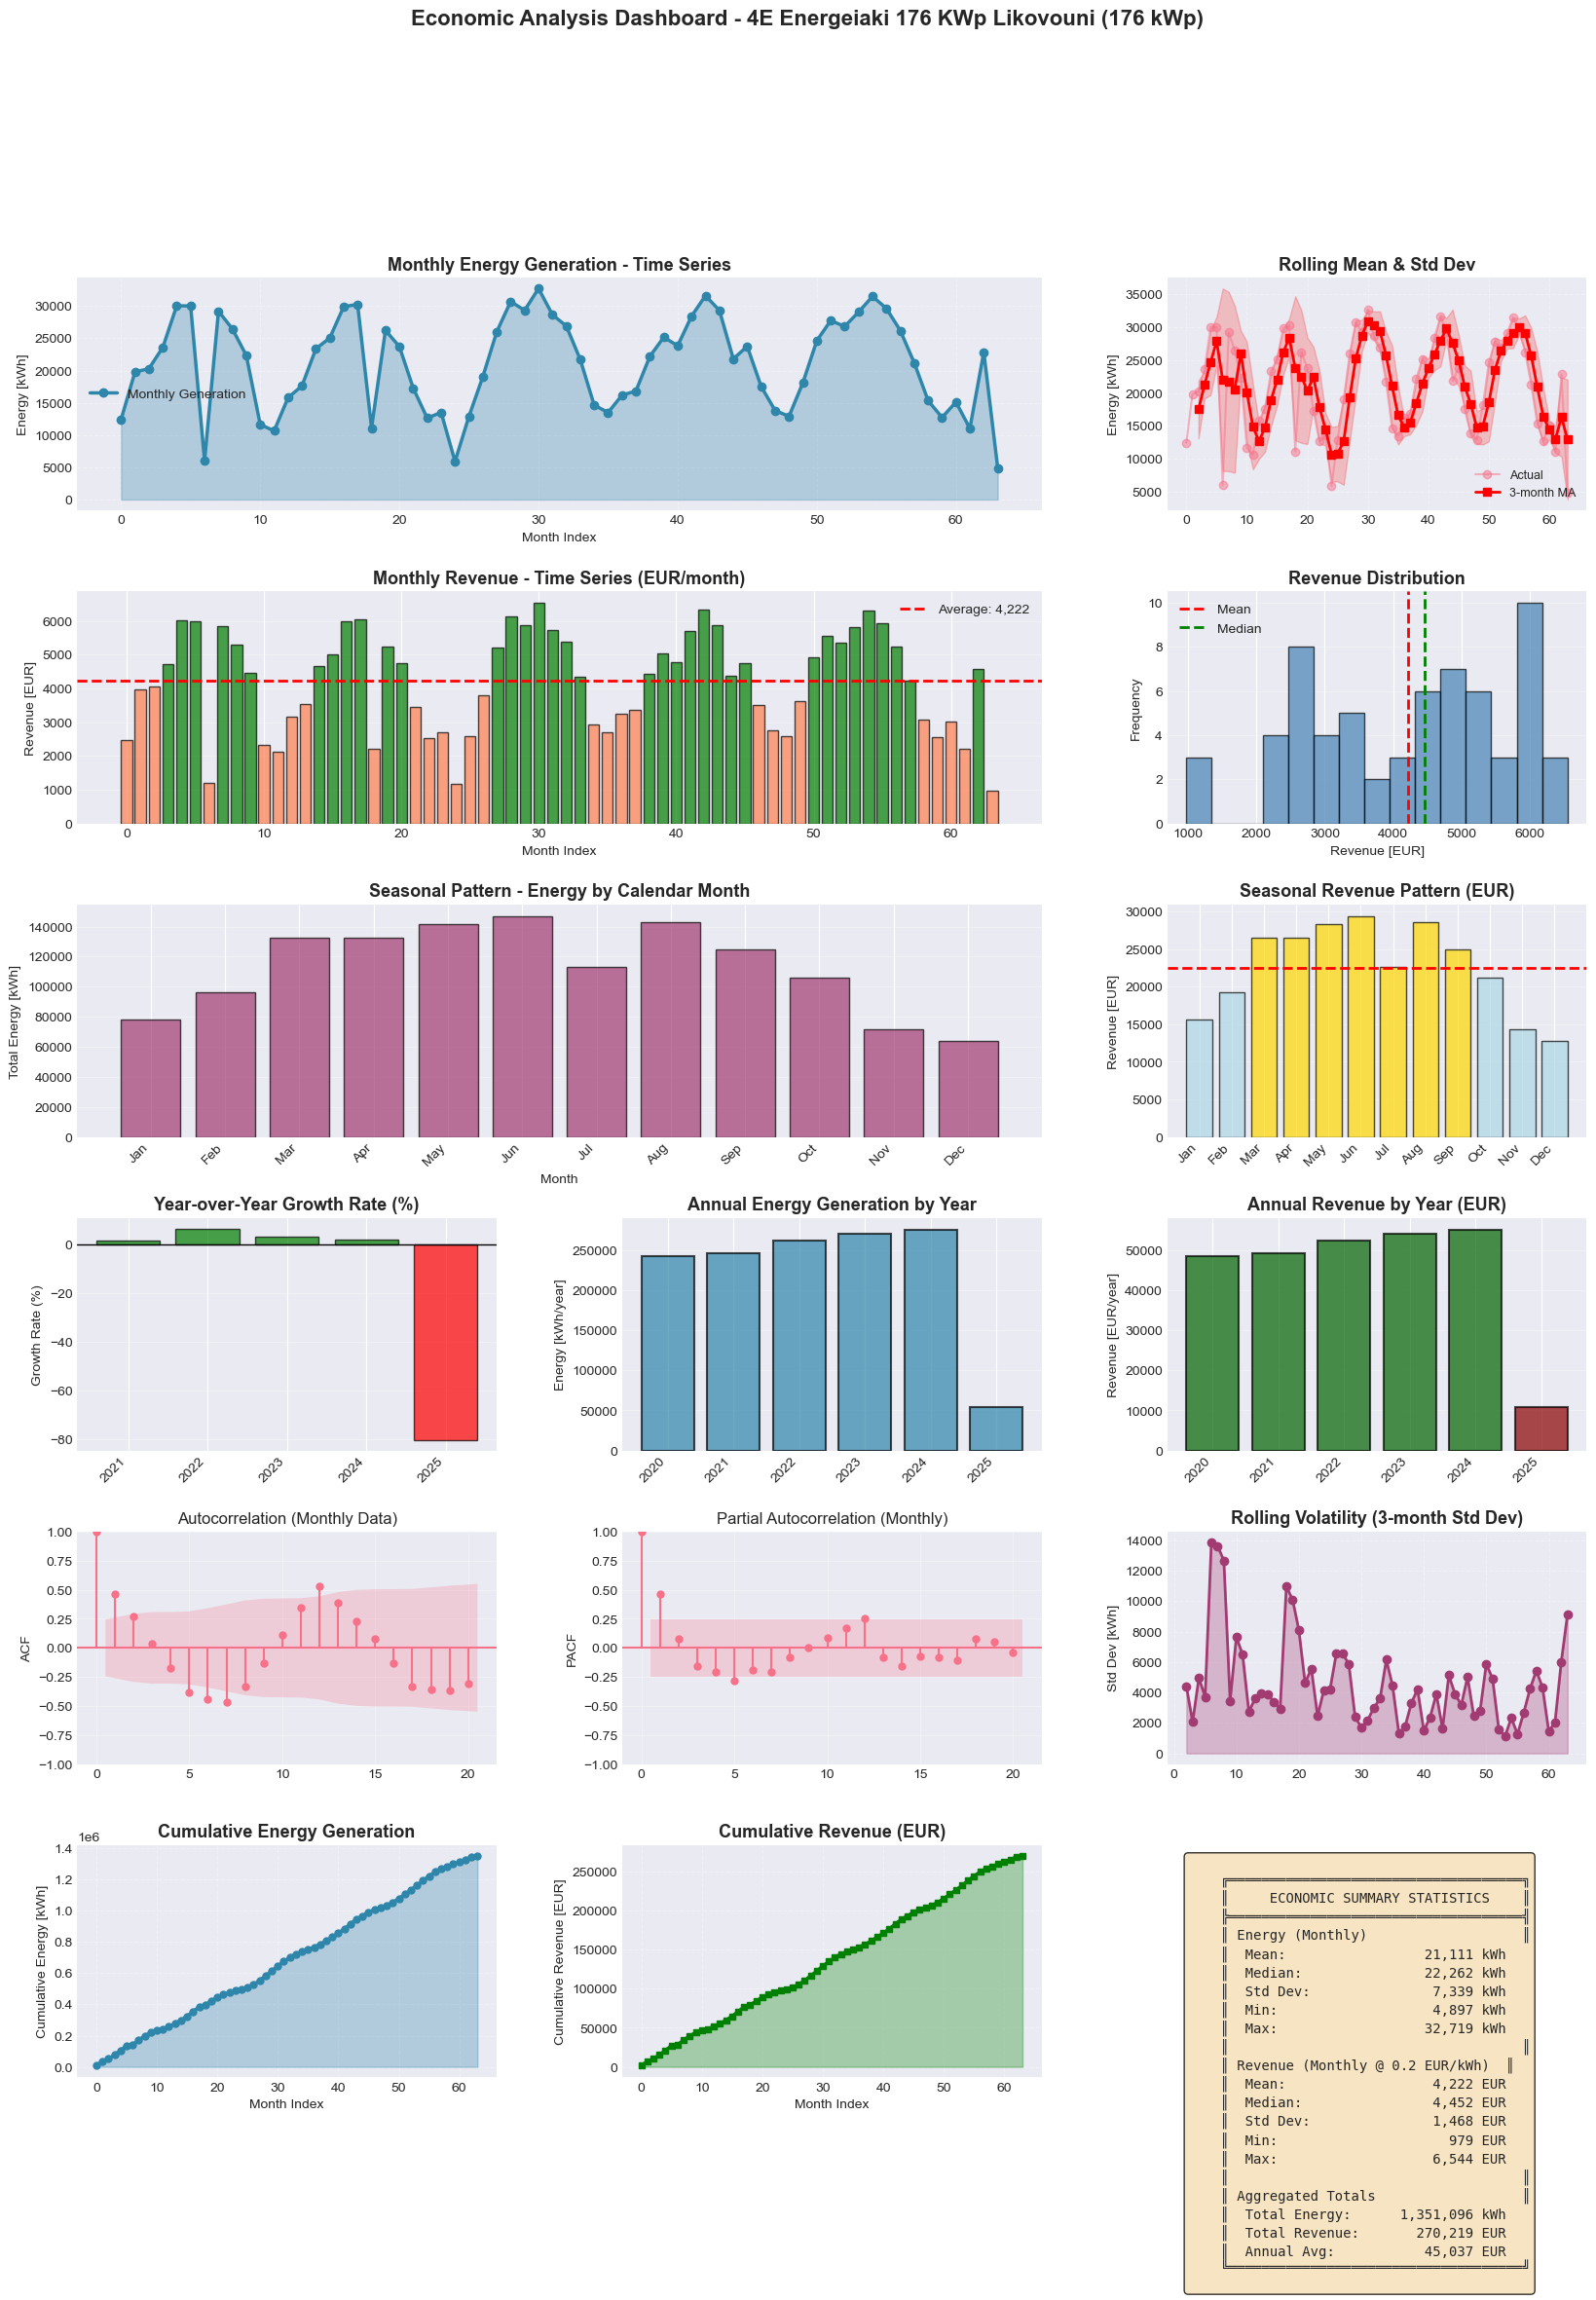


DETAILED ECONOMIC ANALYSIS

📊 ENERGY STATISTICS (Monthly)
   Mean:                       21,111 kWh
   Median:                     22,262 kWh
   Std Deviation:               7,339 kWh
   Coefficient of Variation:  34.76%
   Min/Max Ratio:              0.1497

💰 REVENUE STATISTICS (Monthly @ 0.2 EUR/kWh)
   Mean:                     4,222.17 EUR
   Median:                   4,452.37 EUR
   Std Deviation:            1,467.72 EUR
   Coefficient of Variation:  34.76%

📈 ANNUAL METRICS
   Total Energy (all years):        1,351,096 kWh
   Total Revenue (all years):      270,219.13 EUR
   Average Annual Energy:             225,183 kWh/year
   Average Annual Revenue:          45,036.52 EUR/year

📊 YEAR-OVER-YEAR TRENDS
   Total YoY Growth:                -77.77%
   Average YoY Change:              -13.45%


In [54]:
def create_economic_analysis_dashboard(
    df: pd.DataFrame,
    column: str,
    price_per_kwh: float = 0.2,
    currency: str = "EUR",
    figsize_main: tuple = (20, 24),
    dpi: int = 150,
):
    """
    Create a comprehensive economic analysis dashboard with multiple visualizations.
    
    Includes:
    - Time series of monthly energy and revenue
    - Year-over-year comparison (bar charts)
    - Monthly aggregation to identify seasonal patterns
    - Correlation heatmap between years
    - Autocorrelation analysis (ACF/PACF)
    - Growth rates and year-on-year changes
    - Distribution analysis
    - Rolling statistics (mean, std)
    
    Parameters:
    -----------
    df: pd.DataFrame
        Date-indexed DataFrame with energy data
    column: str
        Column name to analyze
    price_per_kwh: float
        Energy price in currency units (default: 0.2 EUR/kWh)
    currency: str
        Currency code for display (default: "EUR")
    figsize_main: tuple
        Figure size for main dashboard (default: (20, 24))
    dpi: int
        Resolution for the dashboard (default: 150)
    """
    from scipy import stats
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    import warnings
    warnings.filterwarnings('ignore')
    
    if column not in df.columns:
        print(f"❌ Column '{column}' not found")
        return
    
    # Get daily data
    daily_series = df[column].dropna()
    
    # Resample to monthly data
    monthly_data = daily_series.resample('MS').sum()
    monthly_data.index = monthly_data.index.to_period('M')
    
    # Calculate revenue
    monthly_revenue = monthly_data * price_per_kwh
    
    # Create the dashboard
    fig = plt.figure(figsize=figsize_main, facecolor='white')
    gs = fig.add_gridspec(6, 3, hspace=0.35, wspace=0.3)
    
    print(f"📊 Creating Economic Analysis Dashboard for {short_label(column)}")
    print(f"   Data range: {daily_series.index.min()} to {daily_series.index.max()}")
    print(f"   Monthly observations: {len(monthly_data)}")
    
    # ========== 1. Time Series of Monthly Energy ==========
    ax1 = fig.add_subplot(gs[0, :2])
    ax1.plot(range(len(monthly_data)), monthly_data.values, 'o-', linewidth=2.5, 
             markersize=6, color='#2E86AB', label='Monthly Generation')
    ax1.fill_between(range(len(monthly_data)), monthly_data.values, alpha=0.3, color='#2E86AB')
    ax1.set_title('Monthly Energy Generation - Time Series', fontsize=13, fontweight='bold')
    ax1.set_xlabel('Month Index')
    ax1.set_ylabel('Energy [kWh]')
    ax1.grid(alpha=0.3, linestyle='--')
    ax1.legend()
    
    # ========== 2. Rolling Statistics ==========
    ax2 = fig.add_subplot(gs[0, 2])
    rolling_mean = monthly_data.rolling(window=3).mean()
    rolling_std = monthly_data.rolling(window=3).std()
    ax2.plot(range(len(monthly_data)), monthly_data.values, 'o-', alpha=0.5, label='Actual')
    ax2.plot(range(len(rolling_mean)), rolling_mean.values, 's-', linewidth=2, color='red', label='3-month MA')
    ax2.fill_between(range(len(rolling_mean)), 
                     rolling_mean.values - rolling_std.values,
                     rolling_mean.values + rolling_std.values,
                     alpha=0.2, color='red')
    ax2.set_title('Rolling Mean & Std Dev', fontsize=13, fontweight='bold')
    ax2.set_ylabel('Energy [kWh]')
    ax2.legend(fontsize=9)
    ax2.grid(alpha=0.3, linestyle='--')
    
    # ========== 3. Monthly Revenue Time Series ==========
    ax3 = fig.add_subplot(gs[1, :2])
    colors = ['green' if v > monthly_revenue.mean() else 'coral' for v in monthly_revenue.values]
    ax3.bar(range(len(monthly_revenue)), monthly_revenue.values, color=colors, alpha=0.7, edgecolor='black', linewidth=1)
    ax3.axhline(monthly_revenue.mean(), color='red', linestyle='--', linewidth=2, label=f'Average: {monthly_revenue.mean():,.0f}')
    ax3.set_title(f'Monthly Revenue - Time Series ({currency}/month)', fontsize=13, fontweight='bold')
    ax3.set_xlabel('Month Index')
    ax3.set_ylabel(f'Revenue [{currency}]')
    ax3.legend()
    ax3.grid(axis='y', alpha=0.3)
    
    # ========== 4. Revenue Distribution ==========
    ax4 = fig.add_subplot(gs[1, 2])
    ax4.hist(monthly_revenue.values, bins=15, color='steelblue', alpha=0.7, edgecolor='black')
    ax4.axvline(monthly_revenue.mean(), color='red', linestyle='--', linewidth=2, label='Mean')
    ax4.axvline(monthly_revenue.median(), color='green', linestyle='--', linewidth=2, label='Median')
    ax4.set_title('Revenue Distribution', fontsize=13, fontweight='bold')
    ax4.set_xlabel(f'Revenue [{currency}]')
    ax4.set_ylabel('Frequency')
    ax4.legend()
    ax4.grid(axis='y', alpha=0.3)
    
    # ========== 5. Month-to-Date Analysis by Year ==========
    ax5 = fig.add_subplot(gs[2, :2])
    monthly_by_year = daily_series.groupby(daily_series.index.month).sum()
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    ax5.bar(range(len(monthly_by_year)), monthly_by_year.values, color='#A23B72', alpha=0.7, edgecolor='black')
    ax5.set_xticks(range(12))
    ax5.set_xticklabels(months, rotation=45, ha='right')
    ax5.set_title('Seasonal Pattern - Energy by Calendar Month', fontsize=13, fontweight='bold')
    ax5.set_xlabel('Month')
    ax5.set_ylabel('Total Energy [kWh]')
    ax5.grid(axis='y', alpha=0.3)
    
    # ========== 6. Seasonal Revenue ==========
    ax6 = fig.add_subplot(gs[2, 2])
    seasonal_revenue = daily_series.groupby(daily_series.index.month).sum() * price_per_kwh
    colors_seasonal = ['gold' if v > seasonal_revenue.mean() else 'lightblue' for v in seasonal_revenue.values]
    ax6.bar(range(len(seasonal_revenue)), seasonal_revenue.values, color=colors_seasonal, alpha=0.7, edgecolor='black')
    ax6.axhline(seasonal_revenue.mean(), color='red', linestyle='--', linewidth=2)
    ax6.set_xticks(range(12))
    ax6.set_xticklabels(months, rotation=45, ha='right')
    ax6.set_title(f'Seasonal Revenue Pattern ({currency})', fontsize=13, fontweight='bold')
    ax6.set_ylabel(f'Revenue [{currency}]')
    ax6.grid(axis='y', alpha=0.3)
    
    # ========== 7. Year-over-Year Growth Rate ==========
    ax7 = fig.add_subplot(gs[3, 0])
    yearly_energy = daily_series.groupby(daily_series.index.year).sum()
    if len(yearly_energy) > 1:
        yoy_growth = yearly_energy.pct_change() * 100
        yoy_growth_clean = yoy_growth.dropna()  # Remove NaN from first year
        colors_growth = ['green' if x > 0 else 'red' for x in yoy_growth_clean.values]
        ax7.bar(range(len(yoy_growth_clean)), yoy_growth_clean.values, color=colors_growth, alpha=0.7, edgecolor='black')
        ax7.axhline(0, color='black', linewidth=1)
        ax7.set_xticks(range(len(yoy_growth_clean)))
        ax7.set_xticklabels(yoy_growth_clean.index, rotation=45, ha='right')
        ax7.set_title('Year-over-Year Growth Rate (%)', fontsize=13, fontweight='bold')
        ax7.set_ylabel('Growth Rate (%)')
        ax7.grid(axis='y', alpha=0.3)
    
    # ========== 8. Annual Energy by Year ==========
    ax8 = fig.add_subplot(gs[3, 1])
    ax8.bar(range(len(yearly_energy)), yearly_energy.values, color='#2E86AB', alpha=0.7, edgecolor='black', linewidth=1.5)
    ax8.set_xticks(range(len(yearly_energy)))
    ax8.set_xticklabels(yearly_energy.index, rotation=45, ha='right')
    ax8.set_title('Annual Energy Generation by Year', fontsize=13, fontweight='bold')
    ax8.set_ylabel('Energy [kWh/year]')
    ax8.grid(axis='y', alpha=0.3)
    
    # ========== 9. Annual Revenue by Year ==========
    ax9 = fig.add_subplot(gs[3, 2])
    yearly_revenue = yearly_energy * price_per_kwh
    colors_revenue = ['darkgreen' if v > yearly_revenue.mean() else 'darkred' for v in yearly_revenue.values]
    ax9.bar(range(len(yearly_revenue)), yearly_revenue.values, color=colors_revenue, alpha=0.7, edgecolor='black', linewidth=1.5)
    ax9.set_xticks(range(len(yearly_revenue)))
    ax9.set_xticklabels(yearly_revenue.index, rotation=45, ha='right')
    ax9.set_title(f'Annual Revenue by Year ({currency})', fontsize=13, fontweight='bold')
    ax9.set_ylabel(f'Revenue [{currency}/year]')
    ax9.grid(axis='y', alpha=0.3)
    
    # ========== 10. Autocorrelation Function (ACF) ==========
    ax10 = fig.add_subplot(gs[4, 0])
    try:
        plot_acf(monthly_data.dropna(), lags=min(20, len(monthly_data)//2), ax=ax10, title='Autocorrelation (Monthly Data)')
        ax10.set_ylabel('ACF')
        ax10.grid(alpha=0.3)
    except Exception as e:
        ax10.text(0.5, 0.5, f'ACF Error: {str(e)[:30]}', ha='center', va='center')
    
    # ========== 11. Partial Autocorrelation (PACF) ==========
    ax11 = fig.add_subplot(gs[4, 1])
    try:
        plot_pacf(monthly_data.dropna(), lags=min(20, len(monthly_data)//2), ax=ax11, method='ywm', title='Partial Autocorrelation (Monthly)')
        ax11.set_ylabel('PACF')
        ax11.grid(alpha=0.3)
    except Exception as e:
        ax11.text(0.5, 0.5, f'PACF Error: {str(e)[:30]}', ha='center', va='center')
    
    # ========== 12. Monthly Volatility ==========
    ax12 = fig.add_subplot(gs[4, 2])
    monthly_volatility = monthly_data.rolling(window=3).std()
    ax12.plot(range(len(monthly_volatility)), monthly_volatility.values, 'o-', color='#A23B72', linewidth=2, markersize=6)
    ax12.fill_between(range(len(monthly_volatility)), monthly_volatility.values, alpha=0.3, color='#A23B72')
    ax12.set_title('Rolling Volatility (3-month Std Dev)', fontsize=13, fontweight='bold')
    ax12.set_ylabel('Std Dev [kWh]')
    ax12.grid(alpha=0.3, linestyle='--')
    
    # ========== 13. Cumulative Energy & Revenue ==========
    ax13 = fig.add_subplot(gs[5, 0])
    cumsum_energy = monthly_data.cumsum()
    ax13.plot(range(len(cumsum_energy)), cumsum_energy.values, 'o-', linewidth=2.5, color='#2E86AB', markersize=5)
    ax13.fill_between(range(len(cumsum_energy)), cumsum_energy.values, alpha=0.3, color='#2E86AB')
    ax13.set_title('Cumulative Energy Generation', fontsize=13, fontweight='bold')
    ax13.set_xlabel('Month Index')
    ax13.set_ylabel('Cumulative Energy [kWh]')
    ax13.grid(alpha=0.3, linestyle='--')
    
    # ========== 14. Cumulative Revenue ==========
    ax14 = fig.add_subplot(gs[5, 1])
    cumsum_revenue = monthly_revenue.cumsum()
    ax14.plot(range(len(cumsum_revenue)), cumsum_revenue.values, 's-', linewidth=2.5, color='green', markersize=5)
    ax14.fill_between(range(len(cumsum_revenue)), cumsum_revenue.values, alpha=0.3, color='green')
    ax14.set_title(f'Cumulative Revenue ({currency})', fontsize=13, fontweight='bold')
    ax14.set_xlabel('Month Index')
    ax14.set_ylabel(f'Cumulative Revenue [{currency}]')
    ax14.grid(alpha=0.3, linestyle='--')
    
    # ========== 15. Statistical Summary Box ==========
    ax15 = fig.add_subplot(gs[5, 2])
    ax15.axis('off')
    
    # Calculate key statistics
    stats_text = f"""
    ╔════════════════════════════════════╗
    ║     ECONOMIC SUMMARY STATISTICS    ║
    ╠════════════════════════════════════╣
    ║ Energy (Monthly)                   ║
    ║  Mean:        {monthly_data.mean():>15,.0f} kWh
    ║  Median:      {monthly_data.median():>15,.0f} kWh
    ║  Std Dev:     {monthly_data.std():>15,.0f} kWh
    ║  Min:         {monthly_data.min():>15,.0f} kWh
    ║  Max:         {monthly_data.max():>15,.0f} kWh
    ║                                    ║
    ║ Revenue (Monthly @ {price_per_kwh} {currency}/kWh)  ║
    ║  Mean:        {monthly_revenue.mean():>15,.0f} {currency}
    ║  Median:      {monthly_revenue.median():>15,.0f} {currency}
    ║  Std Dev:     {monthly_revenue.std():>15,.0f} {currency}
    ║  Min:         {monthly_revenue.min():>15,.0f} {currency}
    ║  Max:         {monthly_revenue.max():>15,.0f} {currency}
    ║                                    ║
    ║ Aggregated Totals                  ║
    ║  Total Energy: {daily_series.sum():>14,.0f} kWh
    ║  Total Revenue:{yearly_revenue.sum():>14,.0f} {currency}
    ║  Annual Avg:  {yearly_revenue.mean():>15,.0f} {currency}
    ╚════════════════════════════════════╝
    """
    
    ax15.text(0.05, 0.95, stats_text, transform=ax15.transAxes, fontsize=10,
              verticalalignment='top', fontfamily='monospace',
              bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.suptitle(f'Economic Analysis Dashboard - {short_label(column)} ({parse_kwp_from_header(column):.0f} kWp)', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    plt.show()
    
    # Print detailed statistics
    print("\n" + "="*70)
    print("DETAILED ECONOMIC ANALYSIS")
    print("="*70)
    print(f"\n📊 ENERGY STATISTICS (Monthly)")
    print(f"   Mean:              {monthly_data.mean():>15,.0f} kWh")
    print(f"   Median:            {monthly_data.median():>15,.0f} kWh")
    print(f"   Std Deviation:     {monthly_data.std():>15,.0f} kWh")
    print(f"   Coefficient of Variation: {(monthly_data.std()/monthly_data.mean()*100):>6.2f}%")
    print(f"   Min/Max Ratio:     {(monthly_data.min()/monthly_data.max()):>15.4f}")
    
    print(f"\n💰 REVENUE STATISTICS (Monthly @ {price_per_kwh} {currency}/kWh)")
    print(f"   Mean:              {monthly_revenue.mean():>15,.2f} {currency}")
    print(f"   Median:            {monthly_revenue.median():>15,.2f} {currency}")
    print(f"   Std Deviation:     {monthly_revenue.std():>15,.2f} {currency}")
    print(f"   Coefficient of Variation: {(monthly_revenue.std()/monthly_revenue.mean()*100):>6.2f}%")
    
    print(f"\n📈 ANNUAL METRICS")
    print(f"   Total Energy (all years):  {daily_series.sum():>15,.0f} kWh")
    print(f"   Total Revenue (all years): {yearly_revenue.sum():>15,.2f} {currency}")
    print(f"   Average Annual Energy:     {yearly_energy.mean():>15,.0f} kWh/year")
    print(f"   Average Annual Revenue:    {yearly_revenue.mean():>15,.2f} {currency}/year")
    
    if len(yearly_energy) > 1:
        print(f"\n📊 YEAR-OVER-YEAR TRENDS")
        print(f"   Total YoY Growth:        {((yearly_energy.iloc[-1]/yearly_energy.iloc[0])-1)*100:>14.2f}%")
        print(f"   Average YoY Change:      {(yearly_energy.pct_change().mean()*100):>14.2f}%")


# Create dashboard for the first park
if len(daily_historical.columns) > 0:
    first_park = daily_historical.columns[0]
    create_economic_analysis_dashboard(daily_historical, first_park, price_per_kwh=0.2, currency="EUR")


Selected park: [NyConTec 993 Kwp Giannopouleika] PCC PCC active energy export (kWh)
NaN count: 1 out of 377 days

Daily data range: 2025-01-01 00:00:00 to 2026-01-12 00:00:00
Total daily observations: 376 days

AGGREGATING TO MONTHLY DATA

Monthly data range: 2025-01 to 2026-01
Total monthly observations: 13 months

Sample monthly generation (kWh/month):
date
2025-08    143860.858220
2025-09    119745.276564
2025-10     74133.845391
2025-11     47979.914130
2025-12     48438.622529
2026-01     12206.520630
Freq: M, Name: [NyConTec 993 Kwp Giannopouleika] PCC PCC active energy export (kWh), dtype: float64

Train size: 12 months
Test size: 1 month(s)


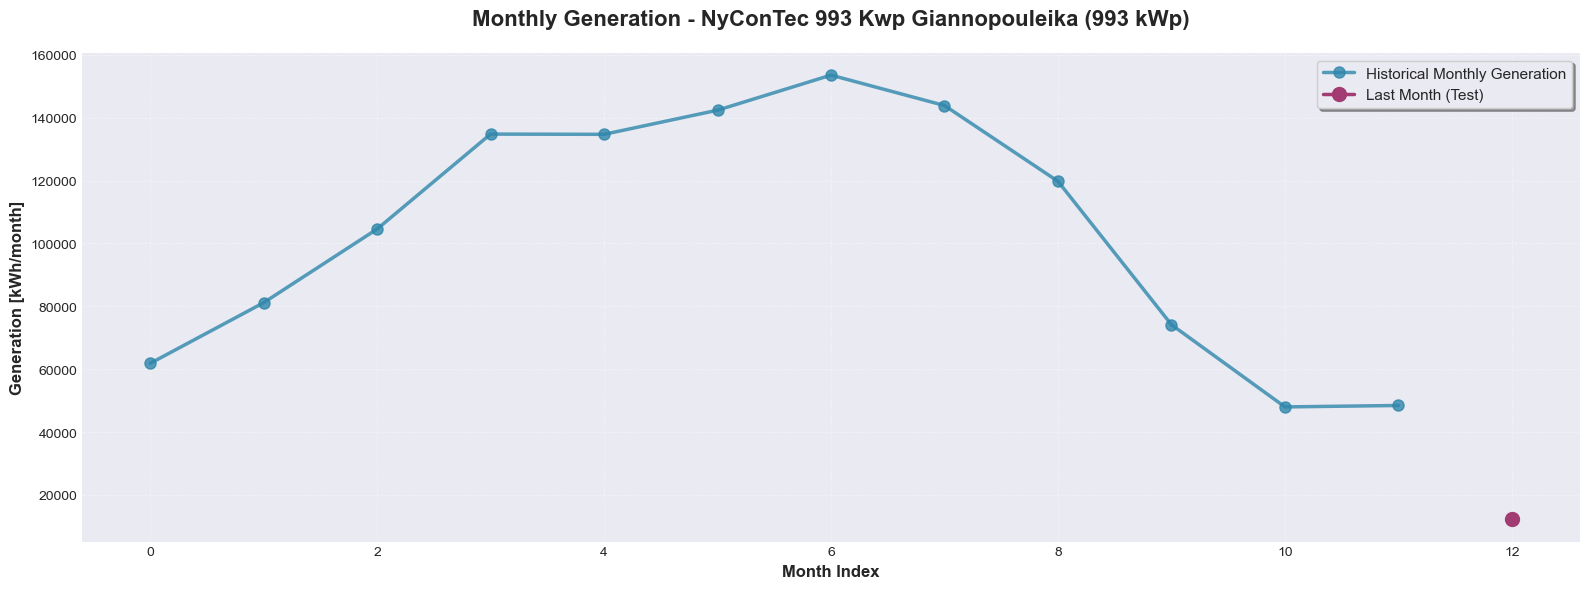

In [43]:
# Time Series Forecasting for PV Generation
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.forecasting.stl import STLForecast
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set beautiful style for plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Select one park with good data coverage (non-NaN)
park_nan_counts = daily.isna().sum()
best_park = park_nan_counts.idxmin()  # Park with least NaN values
print(f"Selected park: {best_park}")
print(f"NaN count: {park_nan_counts[best_park]} out of {len(daily)} days")

# Get the park data and remove NaN values
park_data_daily = daily[best_park].dropna()
print(f"\nDaily data range: {park_data_daily.index.min()} to {park_data_daily.index.max()}")
print(f"Total daily observations: {len(park_data_daily)} days")

# AGGREGATE TO MONTHLY DATA FOR ECONOMIC FORECASTING
print("\n" + "=" * 80)
print("AGGREGATING TO MONTHLY DATA")
print("=" * 80)

# Resample to monthly totals (sum of daily kWh for each month)
monthly_data = park_data_daily.resample('MS').sum()  # 'MS' = Month Start
monthly_data.index = monthly_data.index.to_period('M')  # Convert to period for better display

print(f"\nMonthly data range: {monthly_data.index.min()} to {monthly_data.index.max()}")
print(f"Total monthly observations: {len(monthly_data)} months")
print(f"\nSample monthly generation (kWh/month):")
print(monthly_data.tail(6))

# Split into train and test (use last month as test)
train_data = monthly_data.iloc[:-1]
test_data = monthly_data.iloc[-1:]

print(f"\nTrain size: {len(train_data)} months")
print(f"Test size: {len(test_data)} month(s)")

# Visualize monthly data
fig, ax = plt.subplots(figsize=(16, 6), facecolor='white')
ax.plot(range(len(train_data)), train_data.values, label='Historical Monthly Generation', 
        linewidth=2.5, color='#2E86AB', marker='o', markersize=8, alpha=0.8)
ax.plot(range(len(train_data), len(monthly_data)), test_data.values, 
        label='Last Month (Test)', linewidth=2.5, color='#A23B72', marker='o', markersize=10)

ax.set_title(f"Monthly Generation - {short_label(best_park)} ({parse_kwp_from_header(best_park):.0f} kWp)", 
            fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel("Month Index", fontsize=12, fontweight='bold')
ax.set_ylabel("Generation [kWh/month]", fontsize=12, fontweight='bold')
ax.legend(fontsize=11, frameon=True, shadow=True, fancybox=True)
ax.grid(alpha=0.3, linestyle='--', linewidth=0.7)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()
plt.show()